# Imports

In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Basic GAN (FF+ MNIST)

## Training Setup

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

## Load Mnist dataset (and data loader)

In [0]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,), 
                                     std=(0.5,))])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

total_step = len(data_loader)

## Load Pretrained Model (Optional)

In [0]:
# Load D and G
D.load_state_dict(torch.load('D.ckpt'))
G.load_state_dict(torch.load('G.ckpt'))

## Main Training Loop

Epoch [0/200], Step [200/600], d_loss: 0.0426, g_loss: 4.1674, D(x): 0.99, D(G(z)): 0.03
Epoch [0/200], Step [400/600], d_loss: 0.0615, g_loss: 5.5086, D(x): 0.98, D(G(z)): 0.04
Epoch [0/200], Step [600/600], d_loss: 0.0440, g_loss: 5.3455, D(x): 0.98, D(G(z)): 0.03


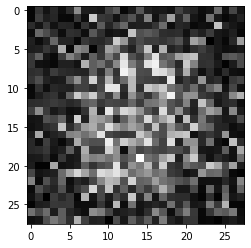

Epoch [1/200], Step [200/600], d_loss: 0.1448, g_loss: 4.6112, D(x): 0.96, D(G(z)): 0.07
Epoch [1/200], Step [400/600], d_loss: 0.1523, g_loss: 5.1739, D(x): 0.95, D(G(z)): 0.03
Epoch [1/200], Step [600/600], d_loss: 0.5306, g_loss: 4.0948, D(x): 0.82, D(G(z)): 0.15


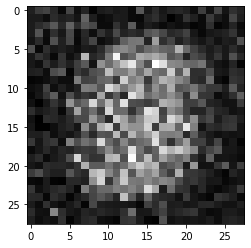

Epoch [2/200], Step [200/600], d_loss: 0.2619, g_loss: 3.4206, D(x): 0.94, D(G(z)): 0.16
Epoch [2/200], Step [400/600], d_loss: 0.2325, g_loss: 3.8741, D(x): 0.90, D(G(z)): 0.07
Epoch [2/200], Step [600/600], d_loss: 1.1684, g_loss: 2.3688, D(x): 0.73, D(G(z)): 0.39


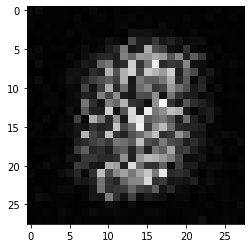

Epoch [3/200], Step [200/600], d_loss: 1.0326, g_loss: 3.5018, D(x): 0.81, D(G(z)): 0.35
Epoch [3/200], Step [400/600], d_loss: 1.1846, g_loss: 2.0840, D(x): 0.70, D(G(z)): 0.36
Epoch [3/200], Step [600/600], d_loss: 0.2868, g_loss: 3.9936, D(x): 0.89, D(G(z)): 0.08


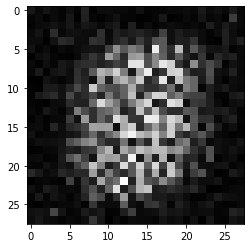

Epoch [4/200], Step [200/600], d_loss: 1.8497, g_loss: 1.4050, D(x): 0.54, D(G(z)): 0.49
Epoch [4/200], Step [400/600], d_loss: 1.8638, g_loss: 1.3937, D(x): 0.61, D(G(z)): 0.60
Epoch [4/200], Step [600/600], d_loss: 0.5426, g_loss: 2.8093, D(x): 0.77, D(G(z)): 0.11


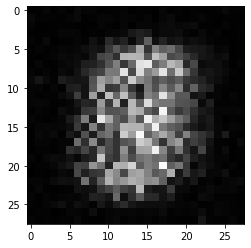

Epoch [5/200], Step [200/600], d_loss: 0.3485, g_loss: 2.6702, D(x): 0.87, D(G(z)): 0.14
Epoch [5/200], Step [400/600], d_loss: 0.2354, g_loss: 3.0071, D(x): 0.92, D(G(z)): 0.12
Epoch [5/200], Step [600/600], d_loss: 0.1734, g_loss: 3.3151, D(x): 0.95, D(G(z)): 0.09


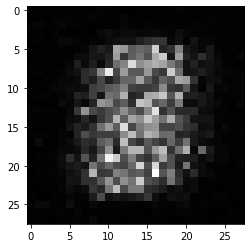

Epoch [6/200], Step [200/600], d_loss: 0.2847, g_loss: 2.9708, D(x): 0.91, D(G(z)): 0.09
Epoch [6/200], Step [400/600], d_loss: 0.3678, g_loss: 3.3879, D(x): 0.90, D(G(z)): 0.12
Epoch [6/200], Step [600/600], d_loss: 0.5830, g_loss: 3.3678, D(x): 0.83, D(G(z)): 0.14


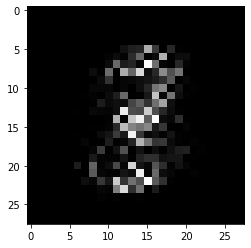

Epoch [7/200], Step [200/600], d_loss: 0.1172, g_loss: 3.6126, D(x): 0.96, D(G(z)): 0.04
Epoch [7/200], Step [400/600], d_loss: 0.1400, g_loss: 4.9279, D(x): 0.97, D(G(z)): 0.07
Epoch [7/200], Step [600/600], d_loss: 0.2553, g_loss: 4.2863, D(x): 0.91, D(G(z)): 0.04


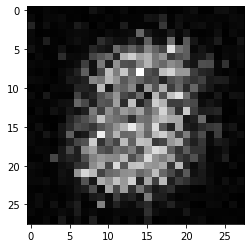

Epoch [8/200], Step [200/600], d_loss: 0.2059, g_loss: 4.4162, D(x): 0.90, D(G(z)): 0.03
Epoch [8/200], Step [400/600], d_loss: 0.0867, g_loss: 4.3531, D(x): 0.99, D(G(z)): 0.07
Epoch [8/200], Step [600/600], d_loss: 0.1179, g_loss: 4.1232, D(x): 0.95, D(G(z)): 0.04


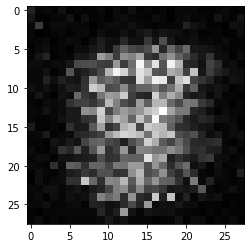

Epoch [9/200], Step [200/600], d_loss: 0.2626, g_loss: 4.7126, D(x): 0.91, D(G(z)): 0.02
Epoch [9/200], Step [400/600], d_loss: 0.1534, g_loss: 4.2253, D(x): 0.95, D(G(z)): 0.05
Epoch [9/200], Step [600/600], d_loss: 0.1697, g_loss: 6.3746, D(x): 0.93, D(G(z)): 0.01


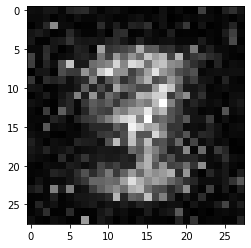

Epoch [10/200], Step [200/600], d_loss: 0.1419, g_loss: 6.2513, D(x): 0.98, D(G(z)): 0.08
Epoch [10/200], Step [400/600], d_loss: 0.1856, g_loss: 5.2710, D(x): 0.93, D(G(z)): 0.04
Epoch [10/200], Step [600/600], d_loss: 0.0542, g_loss: 6.3439, D(x): 0.98, D(G(z)): 0.03


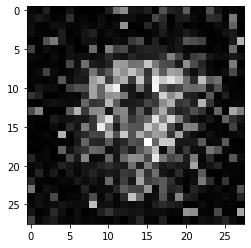

Epoch [11/200], Step [200/600], d_loss: 0.2473, g_loss: 4.4528, D(x): 0.97, D(G(z)): 0.14
Epoch [11/200], Step [400/600], d_loss: 0.0314, g_loss: 5.9834, D(x): 0.99, D(G(z)): 0.01
Epoch [11/200], Step [600/600], d_loss: 0.0959, g_loss: 6.1305, D(x): 0.97, D(G(z)): 0.04


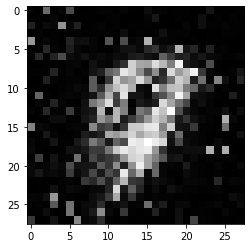

Epoch [12/200], Step [200/600], d_loss: 0.2769, g_loss: 5.6892, D(x): 0.97, D(G(z)): 0.18
Epoch [12/200], Step [400/600], d_loss: 0.0808, g_loss: 4.9743, D(x): 0.98, D(G(z)): 0.04
Epoch [12/200], Step [600/600], d_loss: 0.1274, g_loss: 5.6667, D(x): 0.99, D(G(z)): 0.08


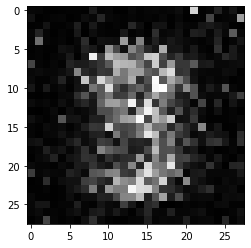

Epoch [13/200], Step [200/600], d_loss: 0.0624, g_loss: 5.7834, D(x): 0.99, D(G(z)): 0.04
Epoch [13/200], Step [400/600], d_loss: 0.2183, g_loss: 5.7512, D(x): 0.95, D(G(z)): 0.05
Epoch [13/200], Step [600/600], d_loss: 0.1567, g_loss: 6.0047, D(x): 0.94, D(G(z)): 0.04


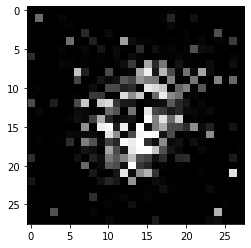

Epoch [14/200], Step [200/600], d_loss: 0.1546, g_loss: 5.3458, D(x): 0.96, D(G(z)): 0.07
Epoch [14/200], Step [400/600], d_loss: 0.4126, g_loss: 5.1288, D(x): 0.89, D(G(z)): 0.04
Epoch [14/200], Step [600/600], d_loss: 0.2523, g_loss: 4.7479, D(x): 0.94, D(G(z)): 0.13


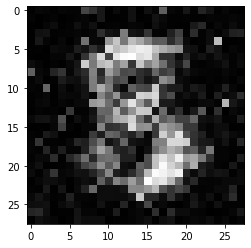

Epoch [15/200], Step [200/600], d_loss: 0.2301, g_loss: 4.8044, D(x): 0.91, D(G(z)): 0.02
Epoch [15/200], Step [400/600], d_loss: 0.0942, g_loss: 7.7340, D(x): 0.94, D(G(z)): 0.00
Epoch [15/200], Step [600/600], d_loss: 0.1291, g_loss: 4.1363, D(x): 0.98, D(G(z)): 0.08


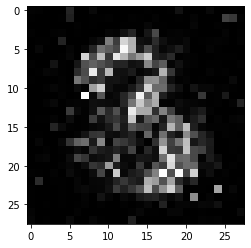

Epoch [16/200], Step [200/600], d_loss: 0.1695, g_loss: 5.8456, D(x): 0.92, D(G(z)): 0.04
Epoch [16/200], Step [400/600], d_loss: 0.2523, g_loss: 6.2168, D(x): 0.93, D(G(z)): 0.04
Epoch [16/200], Step [600/600], d_loss: 0.2197, g_loss: 3.3621, D(x): 0.97, D(G(z)): 0.14


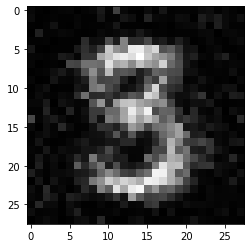

Epoch [17/200], Step [200/600], d_loss: 0.1823, g_loss: 3.1653, D(x): 0.98, D(G(z)): 0.13
Epoch [17/200], Step [400/600], d_loss: 0.4903, g_loss: 3.6371, D(x): 0.93, D(G(z)): 0.22
Epoch [17/200], Step [600/600], d_loss: 0.3046, g_loss: 6.7291, D(x): 0.91, D(G(z)): 0.04


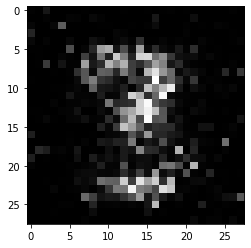

Epoch [18/200], Step [200/600], d_loss: 0.2132, g_loss: 5.9850, D(x): 0.91, D(G(z)): 0.02
Epoch [18/200], Step [400/600], d_loss: 0.1598, g_loss: 5.9414, D(x): 0.96, D(G(z)): 0.07
Epoch [18/200], Step [600/600], d_loss: 0.2338, g_loss: 4.1605, D(x): 0.98, D(G(z)): 0.15


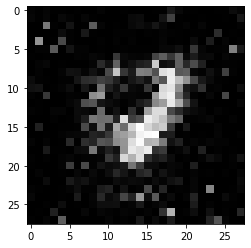

Epoch [19/200], Step [200/600], d_loss: 0.2261, g_loss: 4.6062, D(x): 0.93, D(G(z)): 0.07
Epoch [19/200], Step [400/600], d_loss: 0.1104, g_loss: 4.8966, D(x): 0.95, D(G(z)): 0.03
Epoch [19/200], Step [600/600], d_loss: 0.2209, g_loss: 5.5893, D(x): 0.92, D(G(z)): 0.01


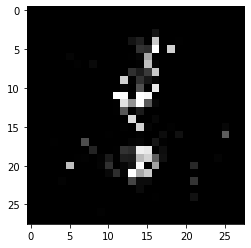

Epoch [20/200], Step [200/600], d_loss: 0.1418, g_loss: 6.0208, D(x): 0.94, D(G(z)): 0.03
Epoch [20/200], Step [400/600], d_loss: 0.1826, g_loss: 3.8358, D(x): 0.94, D(G(z)): 0.05
Epoch [20/200], Step [600/600], d_loss: 0.4306, g_loss: 5.2723, D(x): 0.97, D(G(z)): 0.24


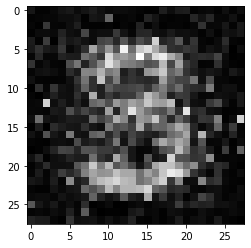

Epoch [21/200], Step [200/600], d_loss: 0.2678, g_loss: 4.3103, D(x): 0.95, D(G(z)): 0.09
Epoch [21/200], Step [400/600], d_loss: 0.1281, g_loss: 4.7135, D(x): 0.98, D(G(z)): 0.08
Epoch [21/200], Step [600/600], d_loss: 0.4148, g_loss: 3.6308, D(x): 0.91, D(G(z)): 0.06


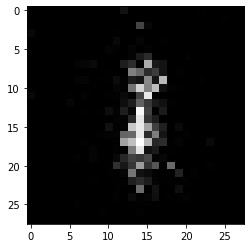

Epoch [22/200], Step [200/600], d_loss: 0.0972, g_loss: 4.6586, D(x): 0.97, D(G(z)): 0.03
Epoch [22/200], Step [400/600], d_loss: 0.1702, g_loss: 2.8629, D(x): 0.94, D(G(z)): 0.06
Epoch [22/200], Step [600/600], d_loss: 0.2621, g_loss: 4.5935, D(x): 0.96, D(G(z)): 0.13


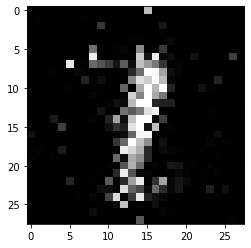

Epoch [23/200], Step [200/600], d_loss: 0.2470, g_loss: 4.3612, D(x): 0.92, D(G(z)): 0.03
Epoch [23/200], Step [400/600], d_loss: 0.1824, g_loss: 3.8382, D(x): 0.93, D(G(z)): 0.05
Epoch [23/200], Step [600/600], d_loss: 0.1563, g_loss: 4.0992, D(x): 0.95, D(G(z)): 0.06


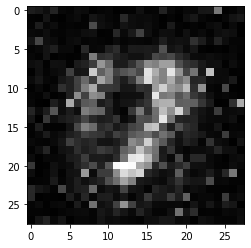

Epoch [24/200], Step [200/600], d_loss: 0.2721, g_loss: 4.9326, D(x): 0.92, D(G(z)): 0.04
Epoch [24/200], Step [400/600], d_loss: 0.1692, g_loss: 3.7994, D(x): 0.93, D(G(z)): 0.04
Epoch [24/200], Step [600/600], d_loss: 0.1673, g_loss: 4.0254, D(x): 0.97, D(G(z)): 0.09


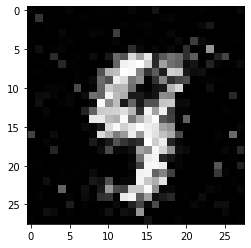

Epoch [25/200], Step [200/600], d_loss: 0.2016, g_loss: 5.4426, D(x): 0.93, D(G(z)): 0.05
Epoch [25/200], Step [400/600], d_loss: 0.1645, g_loss: 5.1448, D(x): 0.98, D(G(z)): 0.11
Epoch [25/200], Step [600/600], d_loss: 0.3237, g_loss: 4.4360, D(x): 0.92, D(G(z)): 0.10


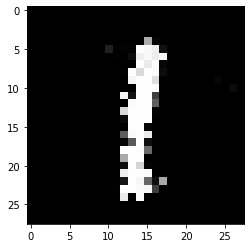

Epoch [26/200], Step [200/600], d_loss: 0.2825, g_loss: 4.4028, D(x): 0.92, D(G(z)): 0.09
Epoch [26/200], Step [400/600], d_loss: 0.4343, g_loss: 3.7950, D(x): 0.91, D(G(z)): 0.10
Epoch [26/200], Step [600/600], d_loss: 0.2258, g_loss: 4.1791, D(x): 0.94, D(G(z)): 0.10


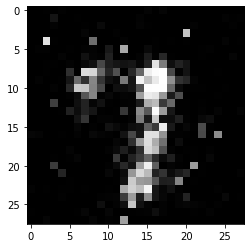

Epoch [27/200], Step [200/600], d_loss: 0.4310, g_loss: 2.9827, D(x): 0.89, D(G(z)): 0.14
Epoch [27/200], Step [400/600], d_loss: 0.3296, g_loss: 3.1337, D(x): 0.94, D(G(z)): 0.14
Epoch [27/200], Step [600/600], d_loss: 0.2981, g_loss: 5.7160, D(x): 0.88, D(G(z)): 0.06


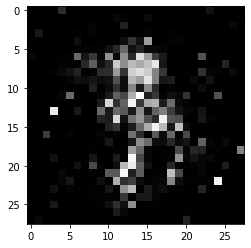

Epoch [28/200], Step [200/600], d_loss: 0.2451, g_loss: 4.5694, D(x): 0.94, D(G(z)): 0.11
Epoch [28/200], Step [400/600], d_loss: 0.1685, g_loss: 4.7942, D(x): 0.94, D(G(z)): 0.06
Epoch [28/200], Step [600/600], d_loss: 0.3609, g_loss: 3.0179, D(x): 0.85, D(G(z)): 0.06


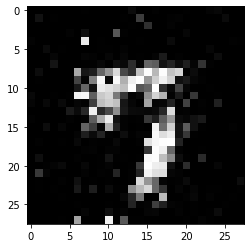

Epoch [29/200], Step [200/600], d_loss: 0.2786, g_loss: 4.0301, D(x): 0.90, D(G(z)): 0.08
Epoch [29/200], Step [400/600], d_loss: 0.3599, g_loss: 4.3521, D(x): 0.96, D(G(z)): 0.18
Epoch [29/200], Step [600/600], d_loss: 0.3932, g_loss: 5.1128, D(x): 0.90, D(G(z)): 0.11


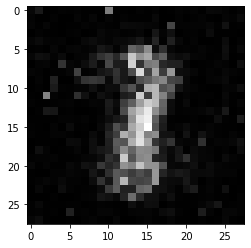

Epoch [30/200], Step [200/600], d_loss: 0.2159, g_loss: 3.4873, D(x): 0.92, D(G(z)): 0.07
Epoch [30/200], Step [400/600], d_loss: 0.4831, g_loss: 4.4639, D(x): 0.85, D(G(z)): 0.06
Epoch [30/200], Step [600/600], d_loss: 0.2443, g_loss: 3.5644, D(x): 0.91, D(G(z)): 0.05


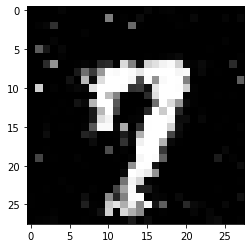

Epoch [31/200], Step [200/600], d_loss: 0.3902, g_loss: 4.3864, D(x): 0.92, D(G(z)): 0.13
Epoch [31/200], Step [400/600], d_loss: 0.4404, g_loss: 4.6174, D(x): 0.84, D(G(z)): 0.09
Epoch [31/200], Step [600/600], d_loss: 0.3762, g_loss: 3.1523, D(x): 0.87, D(G(z)): 0.07


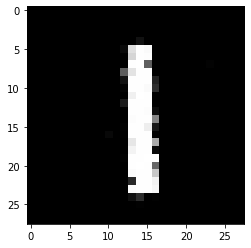

Epoch [32/200], Step [200/600], d_loss: 0.4146, g_loss: 2.5230, D(x): 0.88, D(G(z)): 0.14
Epoch [32/200], Step [400/600], d_loss: 0.3975, g_loss: 2.8830, D(x): 0.84, D(G(z)): 0.08
Epoch [32/200], Step [600/600], d_loss: 0.6457, g_loss: 3.6714, D(x): 0.80, D(G(z)): 0.14


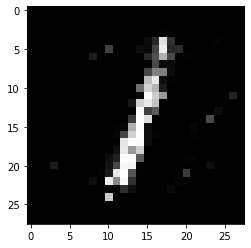

Epoch [33/200], Step [200/600], d_loss: 0.5051, g_loss: 3.4757, D(x): 0.83, D(G(z)): 0.10
Epoch [33/200], Step [400/600], d_loss: 0.5788, g_loss: 4.1313, D(x): 0.79, D(G(z)): 0.07
Epoch [33/200], Step [600/600], d_loss: 0.4607, g_loss: 3.5596, D(x): 0.88, D(G(z)): 0.14


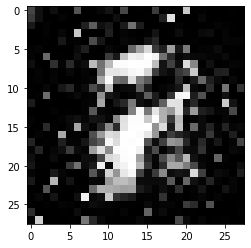

Epoch [34/200], Step [200/600], d_loss: 0.4479, g_loss: 4.2772, D(x): 0.81, D(G(z)): 0.07
Epoch [34/200], Step [400/600], d_loss: 0.4953, g_loss: 3.2225, D(x): 0.86, D(G(z)): 0.13
Epoch [34/200], Step [600/600], d_loss: 0.4064, g_loss: 3.1648, D(x): 0.87, D(G(z)): 0.10


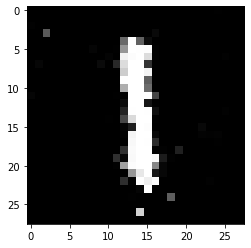

Epoch [35/200], Step [200/600], d_loss: 0.5897, g_loss: 3.4372, D(x): 0.83, D(G(z)): 0.12
Epoch [35/200], Step [400/600], d_loss: 0.4988, g_loss: 3.2448, D(x): 0.86, D(G(z)): 0.17
Epoch [35/200], Step [600/600], d_loss: 0.4965, g_loss: 2.7299, D(x): 0.89, D(G(z)): 0.22


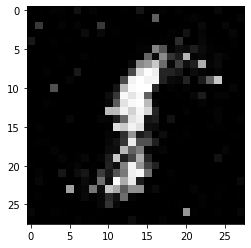

Epoch [36/200], Step [200/600], d_loss: 0.4635, g_loss: 3.2826, D(x): 0.87, D(G(z)): 0.15
Epoch [36/200], Step [400/600], d_loss: 0.6292, g_loss: 3.7910, D(x): 0.82, D(G(z)): 0.16
Epoch [36/200], Step [600/600], d_loss: 0.3202, g_loss: 3.9484, D(x): 0.90, D(G(z)): 0.11


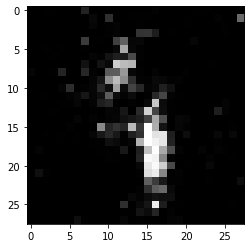

Epoch [37/200], Step [200/600], d_loss: 0.3225, g_loss: 4.1510, D(x): 0.94, D(G(z)): 0.16
Epoch [37/200], Step [400/600], d_loss: 0.3811, g_loss: 3.7337, D(x): 0.92, D(G(z)): 0.16
Epoch [37/200], Step [600/600], d_loss: 0.4710, g_loss: 3.6102, D(x): 0.85, D(G(z)): 0.12


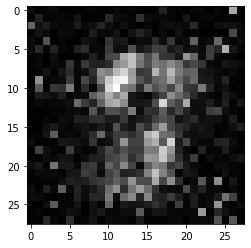

Epoch [38/200], Step [200/600], d_loss: 0.3804, g_loss: 3.7283, D(x): 0.85, D(G(z)): 0.08
Epoch [38/200], Step [400/600], d_loss: 0.3885, g_loss: 2.8392, D(x): 0.91, D(G(z)): 0.17
Epoch [38/200], Step [600/600], d_loss: 0.3285, g_loss: 4.8245, D(x): 0.88, D(G(z)): 0.08


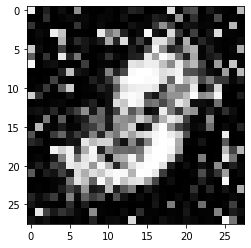

Epoch [39/200], Step [200/600], d_loss: 0.3362, g_loss: 3.5865, D(x): 0.90, D(G(z)): 0.11
Epoch [39/200], Step [400/600], d_loss: 0.3752, g_loss: 2.7697, D(x): 0.90, D(G(z)): 0.14
Epoch [39/200], Step [600/600], d_loss: 0.3856, g_loss: 3.8219, D(x): 0.89, D(G(z)): 0.18


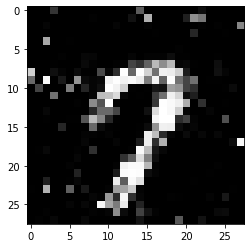

Epoch [40/200], Step [200/600], d_loss: 0.3867, g_loss: 3.6414, D(x): 0.86, D(G(z)): 0.11
Epoch [40/200], Step [400/600], d_loss: 0.2595, g_loss: 3.6802, D(x): 0.90, D(G(z)): 0.07
Epoch [40/200], Step [600/600], d_loss: 0.5113, g_loss: 2.8399, D(x): 0.87, D(G(z)): 0.21


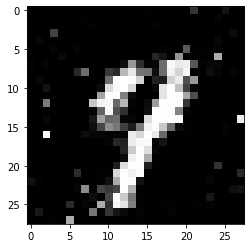

Epoch [41/200], Step [200/600], d_loss: 0.4629, g_loss: 3.8157, D(x): 0.85, D(G(z)): 0.13
Epoch [41/200], Step [400/600], d_loss: 0.4894, g_loss: 2.0593, D(x): 0.89, D(G(z)): 0.22
Epoch [41/200], Step [600/600], d_loss: 0.7513, g_loss: 4.0146, D(x): 0.71, D(G(z)): 0.06


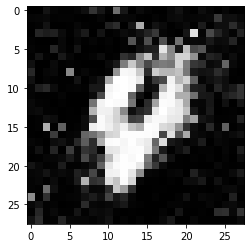

Epoch [42/200], Step [200/600], d_loss: 0.5453, g_loss: 3.3532, D(x): 0.88, D(G(z)): 0.23
Epoch [42/200], Step [400/600], d_loss: 0.4606, g_loss: 2.1755, D(x): 0.83, D(G(z)): 0.13
Epoch [42/200], Step [600/600], d_loss: 0.4667, g_loss: 2.6206, D(x): 0.90, D(G(z)): 0.21


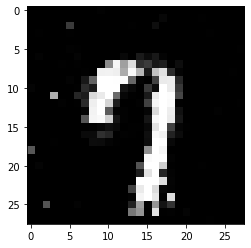

Epoch [43/200], Step [200/600], d_loss: 0.6597, g_loss: 2.7972, D(x): 0.79, D(G(z)): 0.13
Epoch [43/200], Step [400/600], d_loss: 0.6970, g_loss: 2.2492, D(x): 0.74, D(G(z)): 0.17
Epoch [43/200], Step [600/600], d_loss: 0.6899, g_loss: 2.5720, D(x): 0.76, D(G(z)): 0.15


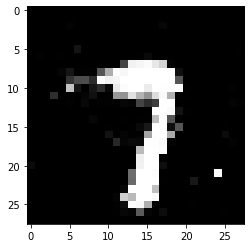

Epoch [44/200], Step [200/600], d_loss: 0.6347, g_loss: 2.5524, D(x): 0.81, D(G(z)): 0.22
Epoch [44/200], Step [400/600], d_loss: 0.5908, g_loss: 2.2274, D(x): 0.82, D(G(z)): 0.17
Epoch [44/200], Step [600/600], d_loss: 0.5153, g_loss: 2.5159, D(x): 0.88, D(G(z)): 0.20


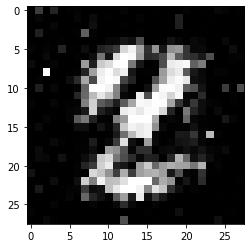

Epoch [45/200], Step [200/600], d_loss: 0.5738, g_loss: 2.2901, D(x): 0.89, D(G(z)): 0.28
Epoch [45/200], Step [400/600], d_loss: 0.5500, g_loss: 2.8809, D(x): 0.87, D(G(z)): 0.26
Epoch [45/200], Step [600/600], d_loss: 0.6080, g_loss: 3.3245, D(x): 0.82, D(G(z)): 0.13


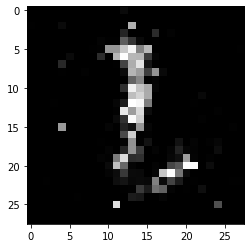

Epoch [46/200], Step [200/600], d_loss: 0.6310, g_loss: 2.7285, D(x): 0.76, D(G(z)): 0.11
Epoch [46/200], Step [400/600], d_loss: 0.5735, g_loss: 2.2221, D(x): 0.80, D(G(z)): 0.18
Epoch [46/200], Step [600/600], d_loss: 0.5797, g_loss: 3.2545, D(x): 0.80, D(G(z)): 0.15


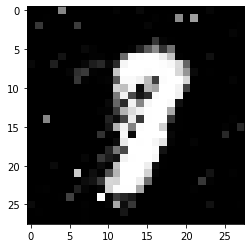

Epoch [47/200], Step [200/600], d_loss: 0.6179, g_loss: 2.3195, D(x): 0.75, D(G(z)): 0.12
Epoch [47/200], Step [400/600], d_loss: 0.3992, g_loss: 3.0211, D(x): 0.86, D(G(z)): 0.13
Epoch [47/200], Step [600/600], d_loss: 0.6493, g_loss: 2.5297, D(x): 0.74, D(G(z)): 0.12


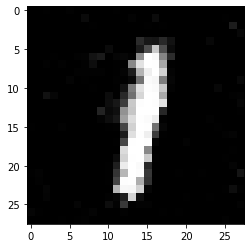

Epoch [48/200], Step [200/600], d_loss: 0.5051, g_loss: 3.8430, D(x): 0.84, D(G(z)): 0.15
Epoch [48/200], Step [400/600], d_loss: 0.4769, g_loss: 2.6158, D(x): 0.86, D(G(z)): 0.18
Epoch [48/200], Step [600/600], d_loss: 0.3361, g_loss: 2.9231, D(x): 0.93, D(G(z)): 0.18


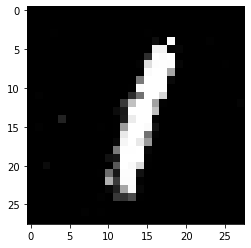

Epoch [49/200], Step [200/600], d_loss: 0.4369, g_loss: 3.6530, D(x): 0.87, D(G(z)): 0.12
Epoch [49/200], Step [400/600], d_loss: 0.4018, g_loss: 3.3717, D(x): 0.82, D(G(z)): 0.06
Epoch [49/200], Step [600/600], d_loss: 0.4087, g_loss: 3.7506, D(x): 0.90, D(G(z)): 0.18


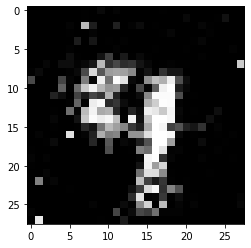

Epoch [50/200], Step [200/600], d_loss: 0.3762, g_loss: 3.1570, D(x): 0.87, D(G(z)): 0.15
Epoch [50/200], Step [400/600], d_loss: 0.5531, g_loss: 2.8816, D(x): 0.81, D(G(z)): 0.13
Epoch [50/200], Step [600/600], d_loss: 0.6898, g_loss: 2.7905, D(x): 0.82, D(G(z)): 0.22


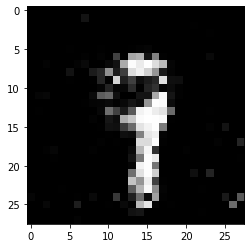

Epoch [51/200], Step [200/600], d_loss: 0.5535, g_loss: 2.6319, D(x): 0.85, D(G(z)): 0.19
Epoch [51/200], Step [400/600], d_loss: 0.4327, g_loss: 2.7986, D(x): 0.88, D(G(z)): 0.19
Epoch [51/200], Step [600/600], d_loss: 0.4210, g_loss: 2.7647, D(x): 0.94, D(G(z)): 0.21


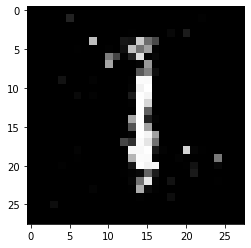

Epoch [52/200], Step [200/600], d_loss: 0.4503, g_loss: 3.4845, D(x): 0.86, D(G(z)): 0.15
Epoch [52/200], Step [400/600], d_loss: 0.4213, g_loss: 3.5819, D(x): 0.84, D(G(z)): 0.11
Epoch [52/200], Step [600/600], d_loss: 0.4292, g_loss: 3.8142, D(x): 0.81, D(G(z)): 0.03


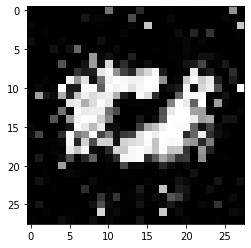

Epoch [53/200], Step [200/600], d_loss: 0.6342, g_loss: 2.8759, D(x): 0.90, D(G(z)): 0.28
Epoch [53/200], Step [400/600], d_loss: 0.6304, g_loss: 3.2316, D(x): 0.85, D(G(z)): 0.23
Epoch [53/200], Step [600/600], d_loss: 0.4877, g_loss: 2.2888, D(x): 0.89, D(G(z)): 0.22


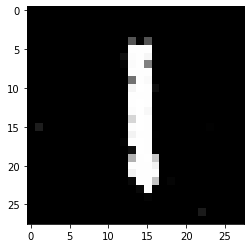

Epoch [54/200], Step [200/600], d_loss: 0.8663, g_loss: 2.4510, D(x): 0.69, D(G(z)): 0.14
Epoch [54/200], Step [400/600], d_loss: 0.6905, g_loss: 3.1747, D(x): 0.84, D(G(z)): 0.29
Epoch [54/200], Step [600/600], d_loss: 0.5890, g_loss: 1.8107, D(x): 0.79, D(G(z)): 0.19


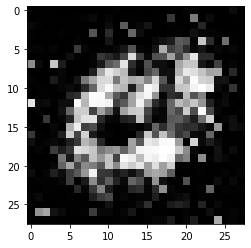

Epoch [55/200], Step [200/600], d_loss: 0.7930, g_loss: 2.3997, D(x): 0.70, D(G(z)): 0.19
Epoch [55/200], Step [400/600], d_loss: 0.6074, g_loss: 2.8929, D(x): 0.74, D(G(z)): 0.11
Epoch [55/200], Step [600/600], d_loss: 0.4178, g_loss: 2.8213, D(x): 0.80, D(G(z)): 0.10


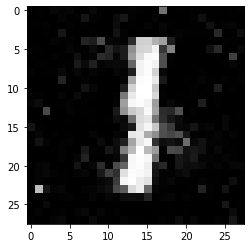

Epoch [56/200], Step [200/600], d_loss: 0.5310, g_loss: 1.9848, D(x): 0.79, D(G(z)): 0.16
Epoch [56/200], Step [400/600], d_loss: 0.8525, g_loss: 1.7665, D(x): 0.71, D(G(z)): 0.22
Epoch [56/200], Step [600/600], d_loss: 0.4860, g_loss: 2.9666, D(x): 0.80, D(G(z)): 0.10


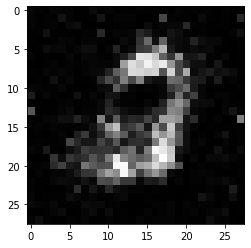

Epoch [57/200], Step [200/600], d_loss: 0.5288, g_loss: 3.2877, D(x): 0.80, D(G(z)): 0.15
Epoch [57/200], Step [400/600], d_loss: 0.5600, g_loss: 2.2358, D(x): 0.85, D(G(z)): 0.24
Epoch [57/200], Step [600/600], d_loss: 0.8358, g_loss: 2.0723, D(x): 0.75, D(G(z)): 0.23


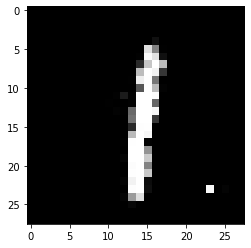

Epoch [58/200], Step [200/600], d_loss: 0.5417, g_loss: 2.6396, D(x): 0.80, D(G(z)): 0.17
Epoch [58/200], Step [400/600], d_loss: 0.7627, g_loss: 1.9733, D(x): 0.81, D(G(z)): 0.29
Epoch [58/200], Step [600/600], d_loss: 0.6364, g_loss: 2.4442, D(x): 0.81, D(G(z)): 0.21


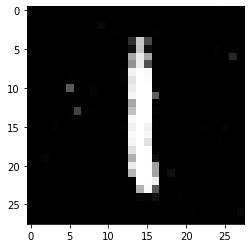

Epoch [59/200], Step [200/600], d_loss: 0.6371, g_loss: 2.5370, D(x): 0.86, D(G(z)): 0.28
Epoch [59/200], Step [400/600], d_loss: 0.6295, g_loss: 2.3783, D(x): 0.82, D(G(z)): 0.24
Epoch [59/200], Step [600/600], d_loss: 0.7703, g_loss: 1.5138, D(x): 0.89, D(G(z)): 0.39


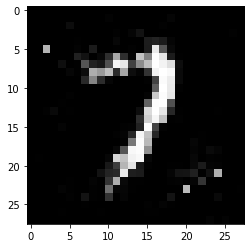

Epoch [60/200], Step [200/600], d_loss: 0.6625, g_loss: 1.9015, D(x): 0.84, D(G(z)): 0.29
Epoch [60/200], Step [400/600], d_loss: 0.5256, g_loss: 2.0247, D(x): 0.85, D(G(z)): 0.22
Epoch [60/200], Step [600/600], d_loss: 0.6994, g_loss: 2.4380, D(x): 0.76, D(G(z)): 0.18


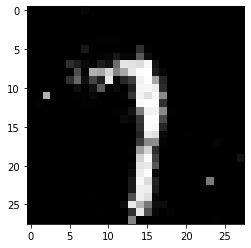

Epoch [61/200], Step [200/600], d_loss: 0.6048, g_loss: 2.4936, D(x): 0.79, D(G(z)): 0.19
Epoch [61/200], Step [400/600], d_loss: 0.7035, g_loss: 1.9007, D(x): 0.79, D(G(z)): 0.22
Epoch [61/200], Step [600/600], d_loss: 0.5811, g_loss: 2.7444, D(x): 0.81, D(G(z)): 0.19


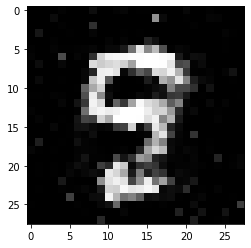

Epoch [62/200], Step [200/600], d_loss: 0.5318, g_loss: 2.5844, D(x): 0.81, D(G(z)): 0.18
Epoch [62/200], Step [400/600], d_loss: 0.5588, g_loss: 2.2821, D(x): 0.86, D(G(z)): 0.24
Epoch [62/200], Step [600/600], d_loss: 0.6365, g_loss: 2.1738, D(x): 0.87, D(G(z)): 0.31


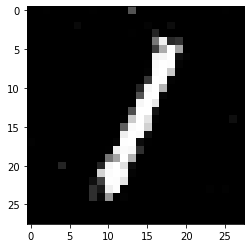

Epoch [63/200], Step [200/600], d_loss: 0.7258, g_loss: 2.5059, D(x): 0.75, D(G(z)): 0.17
Epoch [63/200], Step [400/600], d_loss: 0.4673, g_loss: 2.2847, D(x): 0.87, D(G(z)): 0.20
Epoch [63/200], Step [600/600], d_loss: 0.6412, g_loss: 2.9197, D(x): 0.71, D(G(z)): 0.12


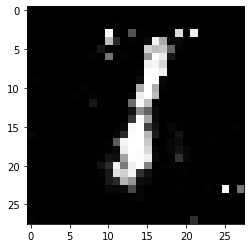

Epoch [64/200], Step [200/600], d_loss: 0.6922, g_loss: 2.0757, D(x): 0.89, D(G(z)): 0.33
Epoch [64/200], Step [400/600], d_loss: 0.4218, g_loss: 3.0904, D(x): 0.87, D(G(z)): 0.17
Epoch [64/200], Step [600/600], d_loss: 0.6374, g_loss: 2.3605, D(x): 0.75, D(G(z)): 0.17


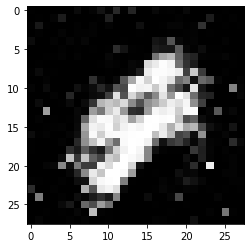

Epoch [65/200], Step [200/600], d_loss: 0.4630, g_loss: 2.5645, D(x): 0.83, D(G(z)): 0.13
Epoch [65/200], Step [400/600], d_loss: 0.6368, g_loss: 2.8668, D(x): 0.81, D(G(z)): 0.20
Epoch [65/200], Step [600/600], d_loss: 0.4715, g_loss: 1.9285, D(x): 0.86, D(G(z)): 0.20


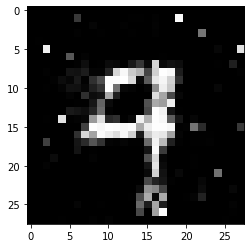

Epoch [66/200], Step [200/600], d_loss: 0.5401, g_loss: 2.5365, D(x): 0.84, D(G(z)): 0.20
Epoch [66/200], Step [400/600], d_loss: 0.7920, g_loss: 2.4006, D(x): 0.75, D(G(z)): 0.22
Epoch [66/200], Step [600/600], d_loss: 0.5822, g_loss: 1.8591, D(x): 0.80, D(G(z)): 0.19


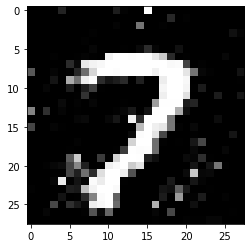

Epoch [67/200], Step [200/600], d_loss: 0.5980, g_loss: 2.9123, D(x): 0.81, D(G(z)): 0.18
Epoch [67/200], Step [400/600], d_loss: 0.6856, g_loss: 2.2438, D(x): 0.77, D(G(z)): 0.19
Epoch [67/200], Step [600/600], d_loss: 0.7326, g_loss: 2.7217, D(x): 0.80, D(G(z)): 0.27


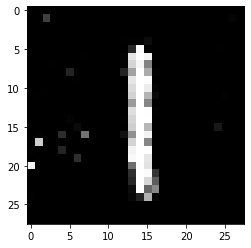

Epoch [68/200], Step [200/600], d_loss: 0.4471, g_loss: 2.6474, D(x): 0.88, D(G(z)): 0.19
Epoch [68/200], Step [400/600], d_loss: 0.6354, g_loss: 3.2195, D(x): 0.81, D(G(z)): 0.20
Epoch [68/200], Step [600/600], d_loss: 0.5689, g_loss: 2.2459, D(x): 0.78, D(G(z)): 0.14


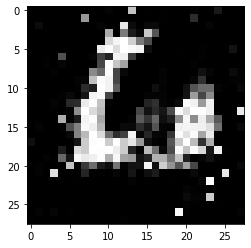

Epoch [69/200], Step [200/600], d_loss: 0.4581, g_loss: 2.7912, D(x): 0.91, D(G(z)): 0.24
Epoch [69/200], Step [400/600], d_loss: 0.8936, g_loss: 2.6935, D(x): 0.79, D(G(z)): 0.28
Epoch [69/200], Step [600/600], d_loss: 0.5740, g_loss: 1.9445, D(x): 0.83, D(G(z)): 0.22


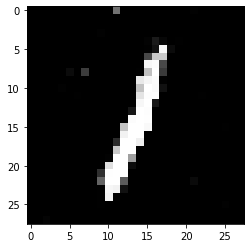

Epoch [70/200], Step [200/600], d_loss: 0.6140, g_loss: 1.9510, D(x): 0.87, D(G(z)): 0.28
Epoch [70/200], Step [400/600], d_loss: 0.6325, g_loss: 2.1917, D(x): 0.90, D(G(z)): 0.32
Epoch [70/200], Step [600/600], d_loss: 0.6264, g_loss: 1.9593, D(x): 0.78, D(G(z)): 0.18


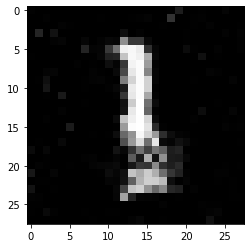

Epoch [71/200], Step [200/600], d_loss: 0.5817, g_loss: 2.4794, D(x): 0.77, D(G(z)): 0.15
Epoch [71/200], Step [400/600], d_loss: 0.6653, g_loss: 2.8815, D(x): 0.71, D(G(z)): 0.12
Epoch [71/200], Step [600/600], d_loss: 0.6660, g_loss: 2.0496, D(x): 0.77, D(G(z)): 0.22


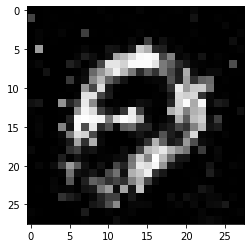

Epoch [72/200], Step [200/600], d_loss: 0.5938, g_loss: 1.7392, D(x): 0.81, D(G(z)): 0.21
Epoch [72/200], Step [400/600], d_loss: 0.8764, g_loss: 3.0360, D(x): 0.75, D(G(z)): 0.29
Epoch [72/200], Step [600/600], d_loss: 0.7626, g_loss: 2.5756, D(x): 0.71, D(G(z)): 0.20


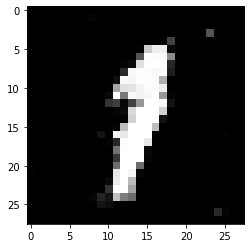

Epoch [73/200], Step [200/600], d_loss: 0.6608, g_loss: 2.0816, D(x): 0.82, D(G(z)): 0.24
Epoch [73/200], Step [400/600], d_loss: 0.5055, g_loss: 2.8133, D(x): 0.80, D(G(z)): 0.15
Epoch [73/200], Step [600/600], d_loss: 0.5791, g_loss: 2.0948, D(x): 0.79, D(G(z)): 0.17


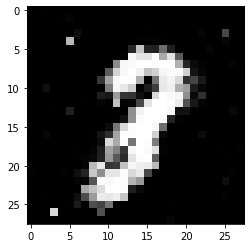

Epoch [74/200], Step [200/600], d_loss: 0.7609, g_loss: 1.9089, D(x): 0.79, D(G(z)): 0.27
Epoch [74/200], Step [400/600], d_loss: 0.6276, g_loss: 2.2483, D(x): 0.82, D(G(z)): 0.25
Epoch [74/200], Step [600/600], d_loss: 0.6866, g_loss: 1.7607, D(x): 0.82, D(G(z)): 0.30


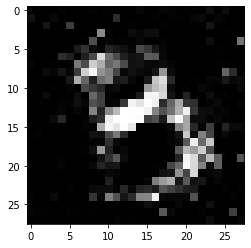

Epoch [75/200], Step [200/600], d_loss: 0.7018, g_loss: 1.9321, D(x): 0.77, D(G(z)): 0.23
Epoch [75/200], Step [400/600], d_loss: 0.6501, g_loss: 2.3240, D(x): 0.79, D(G(z)): 0.22
Epoch [75/200], Step [600/600], d_loss: 0.4515, g_loss: 2.1524, D(x): 0.84, D(G(z)): 0.16


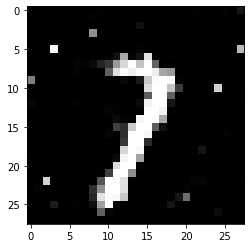

Epoch [76/200], Step [200/600], d_loss: 0.8524, g_loss: 1.7557, D(x): 0.83, D(G(z)): 0.35
Epoch [76/200], Step [400/600], d_loss: 0.6652, g_loss: 2.3407, D(x): 0.76, D(G(z)): 0.20
Epoch [76/200], Step [600/600], d_loss: 0.7177, g_loss: 2.3995, D(x): 0.79, D(G(z)): 0.26


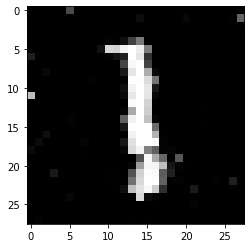

Epoch [77/200], Step [200/600], d_loss: 0.6238, g_loss: 2.6724, D(x): 0.76, D(G(z)): 0.15
Epoch [77/200], Step [400/600], d_loss: 0.6119, g_loss: 2.8504, D(x): 0.79, D(G(z)): 0.20
Epoch [77/200], Step [600/600], d_loss: 0.6431, g_loss: 2.3562, D(x): 0.75, D(G(z)): 0.17


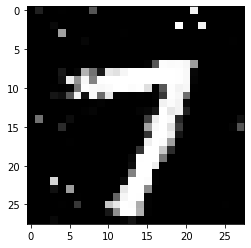

Epoch [78/200], Step [200/600], d_loss: 0.7028, g_loss: 2.0881, D(x): 0.74, D(G(z)): 0.16
Epoch [78/200], Step [400/600], d_loss: 0.6311, g_loss: 2.4109, D(x): 0.86, D(G(z)): 0.29
Epoch [78/200], Step [600/600], d_loss: 0.7226, g_loss: 2.4067, D(x): 0.74, D(G(z)): 0.16


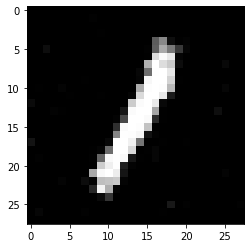

Epoch [79/200], Step [200/600], d_loss: 0.9302, g_loss: 2.5203, D(x): 0.66, D(G(z)): 0.16
Epoch [79/200], Step [400/600], d_loss: 0.5846, g_loss: 1.9879, D(x): 0.75, D(G(z)): 0.13
Epoch [79/200], Step [600/600], d_loss: 0.6898, g_loss: 2.5358, D(x): 0.77, D(G(z)): 0.20


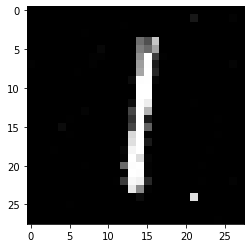

Epoch [80/200], Step [200/600], d_loss: 0.9541, g_loss: 1.9137, D(x): 0.82, D(G(z)): 0.40
Epoch [80/200], Step [400/600], d_loss: 0.7799, g_loss: 2.2171, D(x): 0.73, D(G(z)): 0.20
Epoch [80/200], Step [600/600], d_loss: 0.6293, g_loss: 2.1714, D(x): 0.80, D(G(z)): 0.19


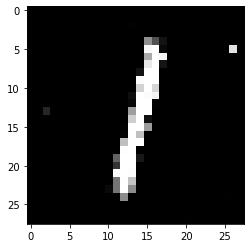

Epoch [81/200], Step [200/600], d_loss: 0.8167, g_loss: 2.1337, D(x): 0.83, D(G(z)): 0.36
Epoch [81/200], Step [400/600], d_loss: 0.7203, g_loss: 2.2773, D(x): 0.76, D(G(z)): 0.22
Epoch [81/200], Step [600/600], d_loss: 0.5638, g_loss: 2.3596, D(x): 0.83, D(G(z)): 0.22


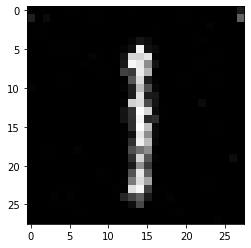

Epoch [82/200], Step [200/600], d_loss: 0.7118, g_loss: 2.0807, D(x): 0.78, D(G(z)): 0.24
Epoch [82/200], Step [400/600], d_loss: 0.5054, g_loss: 1.8330, D(x): 0.90, D(G(z)): 0.25
Epoch [82/200], Step [600/600], d_loss: 0.4699, g_loss: 2.5616, D(x): 0.81, D(G(z)): 0.14


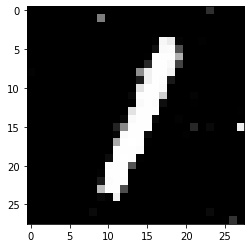

Epoch [83/200], Step [200/600], d_loss: 0.6434, g_loss: 2.4987, D(x): 0.85, D(G(z)): 0.26
Epoch [83/200], Step [400/600], d_loss: 0.7766, g_loss: 2.1703, D(x): 0.78, D(G(z)): 0.29
Epoch [83/200], Step [600/600], d_loss: 0.6215, g_loss: 1.8882, D(x): 0.79, D(G(z)): 0.21


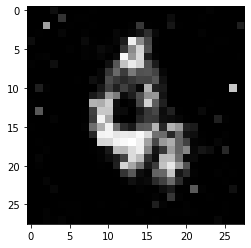

Epoch [84/200], Step [200/600], d_loss: 0.6629, g_loss: 1.7043, D(x): 0.80, D(G(z)): 0.25
Epoch [84/200], Step [400/600], d_loss: 0.6528, g_loss: 2.1214, D(x): 0.80, D(G(z)): 0.26
Epoch [84/200], Step [600/600], d_loss: 0.6329, g_loss: 2.2171, D(x): 0.85, D(G(z)): 0.28


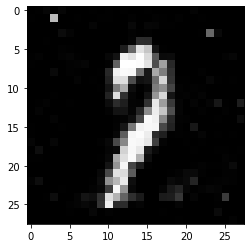

Epoch [85/200], Step [200/600], d_loss: 0.9635, g_loss: 2.6824, D(x): 0.57, D(G(z)): 0.10
Epoch [85/200], Step [400/600], d_loss: 0.7378, g_loss: 2.2332, D(x): 0.78, D(G(z)): 0.25
Epoch [85/200], Step [600/600], d_loss: 0.7582, g_loss: 1.9299, D(x): 0.72, D(G(z)): 0.20


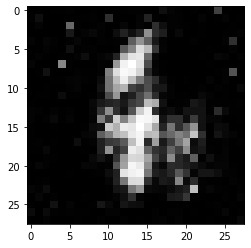

Epoch [86/200], Step [200/600], d_loss: 0.6357, g_loss: 2.2726, D(x): 0.77, D(G(z)): 0.18
Epoch [86/200], Step [400/600], d_loss: 0.7324, g_loss: 1.9677, D(x): 0.74, D(G(z)): 0.20
Epoch [86/200], Step [600/600], d_loss: 0.8083, g_loss: 2.5078, D(x): 0.74, D(G(z)): 0.20


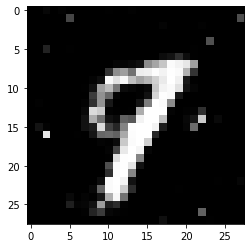

Epoch [87/200], Step [200/600], d_loss: 0.8195, g_loss: 1.7890, D(x): 0.76, D(G(z)): 0.29
Epoch [87/200], Step [400/600], d_loss: 0.7729, g_loss: 2.1179, D(x): 0.80, D(G(z)): 0.29
Epoch [87/200], Step [600/600], d_loss: 0.7230, g_loss: 2.1151, D(x): 0.76, D(G(z)): 0.22


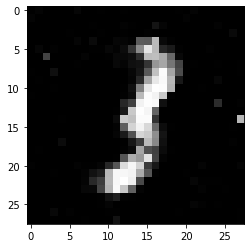

Epoch [88/200], Step [200/600], d_loss: 0.5916, g_loss: 2.2730, D(x): 0.77, D(G(z)): 0.21
Epoch [88/200], Step [400/600], d_loss: 0.7596, g_loss: 1.9183, D(x): 0.68, D(G(z)): 0.16
Epoch [88/200], Step [600/600], d_loss: 0.6358, g_loss: 1.8838, D(x): 0.77, D(G(z)): 0.22


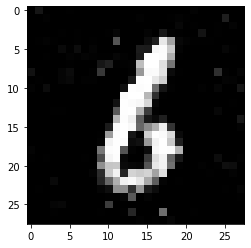

Epoch [89/200], Step [200/600], d_loss: 0.7289, g_loss: 1.4375, D(x): 0.82, D(G(z)): 0.28
Epoch [89/200], Step [400/600], d_loss: 0.8515, g_loss: 1.8197, D(x): 0.76, D(G(z)): 0.31
Epoch [89/200], Step [600/600], d_loss: 0.7825, g_loss: 1.9833, D(x): 0.82, D(G(z)): 0.33


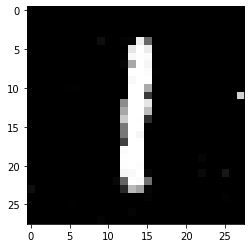

Epoch [90/200], Step [200/600], d_loss: 0.5888, g_loss: 2.1816, D(x): 0.80, D(G(z)): 0.20
Epoch [90/200], Step [400/600], d_loss: 0.8236, g_loss: 1.9877, D(x): 0.67, D(G(z)): 0.19
Epoch [90/200], Step [600/600], d_loss: 0.7015, g_loss: 2.6206, D(x): 0.82, D(G(z)): 0.27


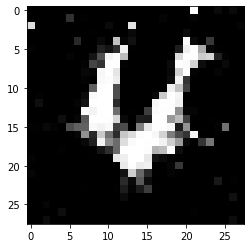

Epoch [91/200], Step [200/600], d_loss: 0.8762, g_loss: 2.2324, D(x): 0.72, D(G(z)): 0.23
Epoch [91/200], Step [400/600], d_loss: 0.8505, g_loss: 2.6878, D(x): 0.68, D(G(z)): 0.18
Epoch [91/200], Step [600/600], d_loss: 0.7528, g_loss: 1.9624, D(x): 0.73, D(G(z)): 0.23


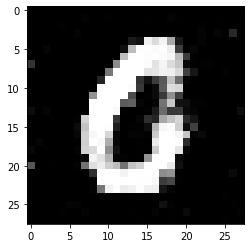

Epoch [92/200], Step [200/600], d_loss: 0.8708, g_loss: 1.7289, D(x): 0.73, D(G(z)): 0.25
Epoch [92/200], Step [400/600], d_loss: 0.8773, g_loss: 1.8170, D(x): 0.73, D(G(z)): 0.29
Epoch [92/200], Step [600/600], d_loss: 0.9830, g_loss: 1.8300, D(x): 0.69, D(G(z)): 0.30


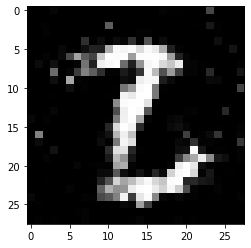

Epoch [93/200], Step [200/600], d_loss: 0.9097, g_loss: 2.0174, D(x): 0.71, D(G(z)): 0.30
Epoch [93/200], Step [400/600], d_loss: 0.7666, g_loss: 1.6535, D(x): 0.75, D(G(z)): 0.25
Epoch [93/200], Step [600/600], d_loss: 0.6638, g_loss: 2.0731, D(x): 0.89, D(G(z)): 0.34


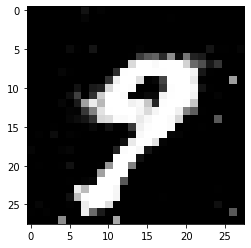

Epoch [94/200], Step [200/600], d_loss: 0.8436, g_loss: 1.9082, D(x): 0.71, D(G(z)): 0.22
Epoch [94/200], Step [400/600], d_loss: 0.7297, g_loss: 2.2215, D(x): 0.72, D(G(z)): 0.20
Epoch [94/200], Step [600/600], d_loss: 0.7025, g_loss: 2.1317, D(x): 0.70, D(G(z)): 0.18


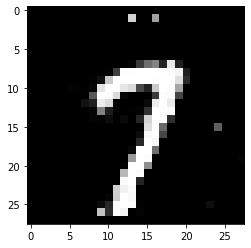

Epoch [95/200], Step [200/600], d_loss: 0.8672, g_loss: 1.7063, D(x): 0.70, D(G(z)): 0.26
Epoch [95/200], Step [400/600], d_loss: 0.8214, g_loss: 1.7661, D(x): 0.72, D(G(z)): 0.25
Epoch [95/200], Step [600/600], d_loss: 0.9564, g_loss: 1.9812, D(x): 0.73, D(G(z)): 0.31


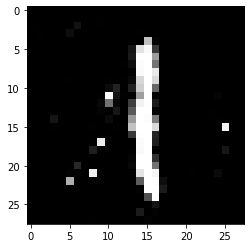

Epoch [96/200], Step [200/600], d_loss: 0.8134, g_loss: 1.8605, D(x): 0.71, D(G(z)): 0.27
Epoch [96/200], Step [400/600], d_loss: 0.8123, g_loss: 1.6917, D(x): 0.79, D(G(z)): 0.33
Epoch [96/200], Step [600/600], d_loss: 0.9070, g_loss: 1.5318, D(x): 0.64, D(G(z)): 0.22


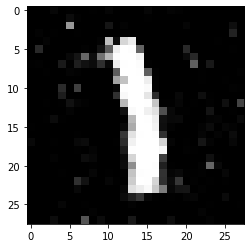

Epoch [97/200], Step [200/600], d_loss: 0.8487, g_loss: 1.8333, D(x): 0.72, D(G(z)): 0.26
Epoch [97/200], Step [400/600], d_loss: 0.6566, g_loss: 2.6073, D(x): 0.73, D(G(z)): 0.16
Epoch [97/200], Step [600/600], d_loss: 0.9690, g_loss: 2.1332, D(x): 0.65, D(G(z)): 0.22


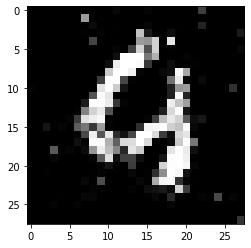

Epoch [98/200], Step [200/600], d_loss: 0.8740, g_loss: 2.3952, D(x): 0.75, D(G(z)): 0.26
Epoch [98/200], Step [400/600], d_loss: 0.7866, g_loss: 1.9826, D(x): 0.75, D(G(z)): 0.28
Epoch [98/200], Step [600/600], d_loss: 1.1358, g_loss: 1.7431, D(x): 0.65, D(G(z)): 0.29


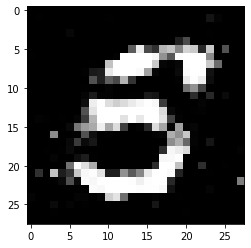

Epoch [99/200], Step [200/600], d_loss: 0.7478, g_loss: 2.1791, D(x): 0.79, D(G(z)): 0.29
Epoch [99/200], Step [400/600], d_loss: 0.5903, g_loss: 1.9370, D(x): 0.77, D(G(z)): 0.20
Epoch [99/200], Step [600/600], d_loss: 0.7061, g_loss: 2.4987, D(x): 0.73, D(G(z)): 0.19


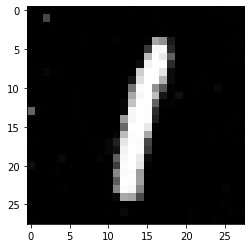

Epoch [100/200], Step [200/600], d_loss: 0.6720, g_loss: 1.9195, D(x): 0.76, D(G(z)): 0.21
Epoch [100/200], Step [400/600], d_loss: 0.7940, g_loss: 2.6237, D(x): 0.67, D(G(z)): 0.11
Epoch [100/200], Step [600/600], d_loss: 0.8546, g_loss: 1.8061, D(x): 0.76, D(G(z)): 0.32


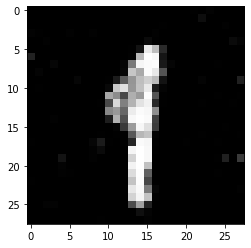

Epoch [101/200], Step [200/600], d_loss: 0.9988, g_loss: 1.6285, D(x): 0.70, D(G(z)): 0.29
Epoch [101/200], Step [400/600], d_loss: 0.7020, g_loss: 1.7099, D(x): 0.77, D(G(z)): 0.26
Epoch [101/200], Step [600/600], d_loss: 0.8352, g_loss: 1.8487, D(x): 0.75, D(G(z)): 0.27


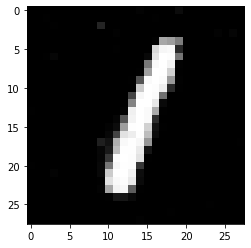

Epoch [102/200], Step [200/600], d_loss: 0.8606, g_loss: 1.9487, D(x): 0.77, D(G(z)): 0.33
Epoch [102/200], Step [400/600], d_loss: 0.8723, g_loss: 1.7100, D(x): 0.74, D(G(z)): 0.31
Epoch [102/200], Step [600/600], d_loss: 0.9006, g_loss: 1.7577, D(x): 0.73, D(G(z)): 0.27


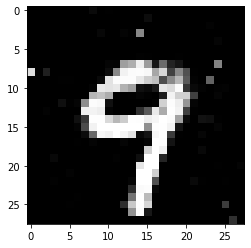

Epoch [103/200], Step [200/600], d_loss: 0.8335, g_loss: 1.6540, D(x): 0.79, D(G(z)): 0.33
Epoch [103/200], Step [400/600], d_loss: 0.7543, g_loss: 1.8943, D(x): 0.82, D(G(z)): 0.32
Epoch [103/200], Step [600/600], d_loss: 0.8913, g_loss: 1.3395, D(x): 0.77, D(G(z)): 0.37


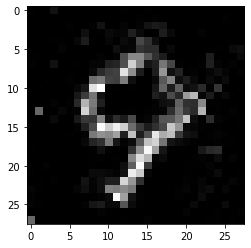

Epoch [104/200], Step [200/600], d_loss: 0.6301, g_loss: 1.8129, D(x): 0.84, D(G(z)): 0.28
Epoch [104/200], Step [400/600], d_loss: 0.7494, g_loss: 1.7097, D(x): 0.81, D(G(z)): 0.33
Epoch [104/200], Step [600/600], d_loss: 0.8231, g_loss: 1.2466, D(x): 0.73, D(G(z)): 0.27


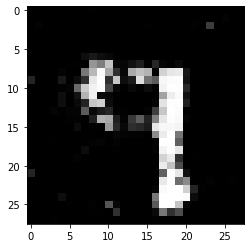

Epoch [105/200], Step [200/600], d_loss: 0.6822, g_loss: 1.8554, D(x): 0.76, D(G(z)): 0.21
Epoch [105/200], Step [400/600], d_loss: 0.7304, g_loss: 1.5906, D(x): 0.79, D(G(z)): 0.26
Epoch [105/200], Step [600/600], d_loss: 0.9628, g_loss: 1.9339, D(x): 0.80, D(G(z)): 0.38


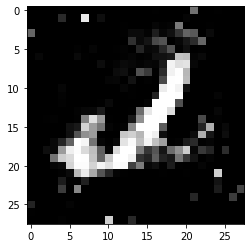

Epoch [106/200], Step [200/600], d_loss: 0.9176, g_loss: 1.6395, D(x): 0.79, D(G(z)): 0.36
Epoch [106/200], Step [400/600], d_loss: 1.0186, g_loss: 1.8504, D(x): 0.78, D(G(z)): 0.36
Epoch [106/200], Step [600/600], d_loss: 0.9204, g_loss: 1.6398, D(x): 0.68, D(G(z)): 0.27


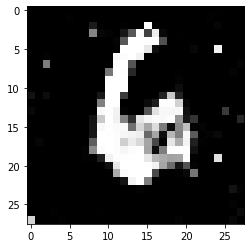

Epoch [107/200], Step [200/600], d_loss: 0.8685, g_loss: 2.3356, D(x): 0.64, D(G(z)): 0.17
Epoch [107/200], Step [400/600], d_loss: 0.7949, g_loss: 1.7915, D(x): 0.72, D(G(z)): 0.22
Epoch [107/200], Step [600/600], d_loss: 0.7234, g_loss: 1.7444, D(x): 0.78, D(G(z)): 0.25


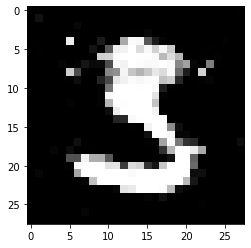

Epoch [108/200], Step [200/600], d_loss: 0.8524, g_loss: 1.3584, D(x): 0.77, D(G(z)): 0.33
Epoch [108/200], Step [400/600], d_loss: 0.7670, g_loss: 1.9379, D(x): 0.76, D(G(z)): 0.26
Epoch [108/200], Step [600/600], d_loss: 0.7102, g_loss: 2.2438, D(x): 0.81, D(G(z)): 0.27


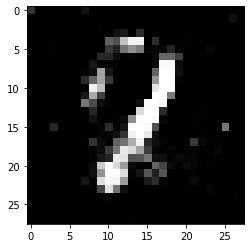

Epoch [109/200], Step [200/600], d_loss: 0.5611, g_loss: 1.2142, D(x): 0.84, D(G(z)): 0.25
Epoch [109/200], Step [400/600], d_loss: 0.6899, g_loss: 1.8899, D(x): 0.77, D(G(z)): 0.23
Epoch [109/200], Step [600/600], d_loss: 0.8187, g_loss: 1.9950, D(x): 0.68, D(G(z)): 0.20


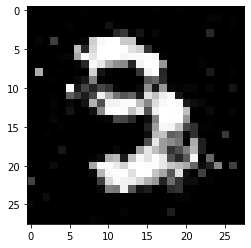

Epoch [110/200], Step [200/600], d_loss: 0.8001, g_loss: 2.1771, D(x): 0.68, D(G(z)): 0.14
Epoch [110/200], Step [400/600], d_loss: 1.0023, g_loss: 1.9195, D(x): 0.72, D(G(z)): 0.34
Epoch [110/200], Step [600/600], d_loss: 0.9007, g_loss: 1.8978, D(x): 0.68, D(G(z)): 0.24


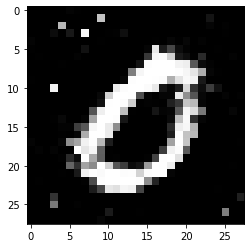

Epoch [111/200], Step [200/600], d_loss: 0.9266, g_loss: 2.0568, D(x): 0.72, D(G(z)): 0.27
Epoch [111/200], Step [400/600], d_loss: 0.9245, g_loss: 1.2963, D(x): 0.74, D(G(z)): 0.31
Epoch [111/200], Step [600/600], d_loss: 0.9561, g_loss: 2.0710, D(x): 0.64, D(G(z)): 0.23


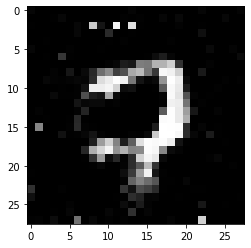

Epoch [112/200], Step [200/600], d_loss: 0.5643, g_loss: 1.8645, D(x): 0.85, D(G(z)): 0.26
Epoch [112/200], Step [400/600], d_loss: 0.8179, g_loss: 1.9101, D(x): 0.79, D(G(z)): 0.34
Epoch [112/200], Step [600/600], d_loss: 0.8898, g_loss: 1.8246, D(x): 0.75, D(G(z)): 0.32


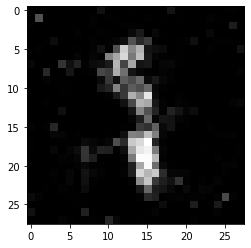

Epoch [113/200], Step [200/600], d_loss: 0.7018, g_loss: 2.1108, D(x): 0.77, D(G(z)): 0.24
Epoch [113/200], Step [400/600], d_loss: 0.6629, g_loss: 1.8032, D(x): 0.81, D(G(z)): 0.27
Epoch [113/200], Step [600/600], d_loss: 0.6576, g_loss: 1.9441, D(x): 0.74, D(G(z)): 0.17


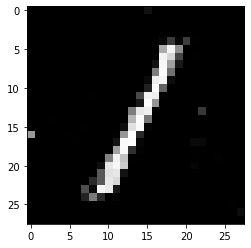

Epoch [114/200], Step [200/600], d_loss: 0.7977, g_loss: 2.6609, D(x): 0.71, D(G(z)): 0.23
Epoch [114/200], Step [400/600], d_loss: 0.9310, g_loss: 1.4449, D(x): 0.83, D(G(z)): 0.43
Epoch [114/200], Step [600/600], d_loss: 0.7622, g_loss: 2.0404, D(x): 0.74, D(G(z)): 0.27


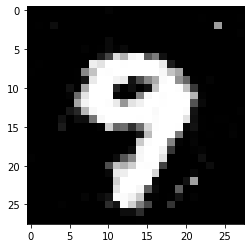

Epoch [115/200], Step [200/600], d_loss: 0.8914, g_loss: 1.6716, D(x): 0.66, D(G(z)): 0.20
Epoch [115/200], Step [400/600], d_loss: 0.7439, g_loss: 1.6881, D(x): 0.84, D(G(z)): 0.33
Epoch [115/200], Step [600/600], d_loss: 0.8105, g_loss: 1.8737, D(x): 0.72, D(G(z)): 0.25


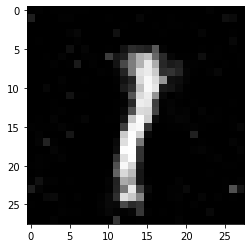

Epoch [116/200], Step [200/600], d_loss: 0.8064, g_loss: 1.9510, D(x): 0.76, D(G(z)): 0.28
Epoch [116/200], Step [400/600], d_loss: 0.8526, g_loss: 1.9857, D(x): 0.84, D(G(z)): 0.37
Epoch [116/200], Step [600/600], d_loss: 0.8268, g_loss: 2.0605, D(x): 0.69, D(G(z)): 0.23


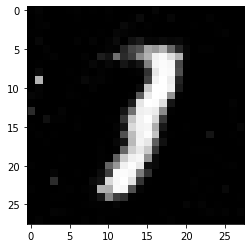

Epoch [117/200], Step [200/600], d_loss: 0.6312, g_loss: 2.1439, D(x): 0.78, D(G(z)): 0.22
Epoch [117/200], Step [400/600], d_loss: 0.8970, g_loss: 1.8948, D(x): 0.75, D(G(z)): 0.30
Epoch [117/200], Step [600/600], d_loss: 0.7331, g_loss: 1.2542, D(x): 0.81, D(G(z)): 0.32


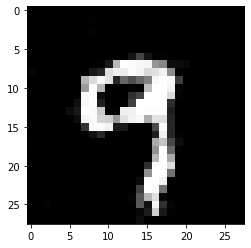

Epoch [118/200], Step [200/600], d_loss: 0.8439, g_loss: 1.8980, D(x): 0.78, D(G(z)): 0.32
Epoch [118/200], Step [400/600], d_loss: 1.0965, g_loss: 1.4567, D(x): 0.62, D(G(z)): 0.27
Epoch [118/200], Step [600/600], d_loss: 0.8860, g_loss: 1.7616, D(x): 0.65, D(G(z)): 0.23


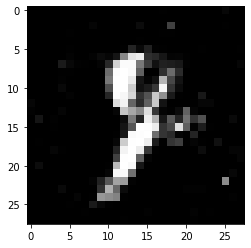

Epoch [119/200], Step [200/600], d_loss: 0.8715, g_loss: 1.4797, D(x): 0.71, D(G(z)): 0.26
Epoch [119/200], Step [400/600], d_loss: 0.7989, g_loss: 1.8228, D(x): 0.72, D(G(z)): 0.26
Epoch [119/200], Step [600/600], d_loss: 0.8245, g_loss: 1.7719, D(x): 0.81, D(G(z)): 0.34


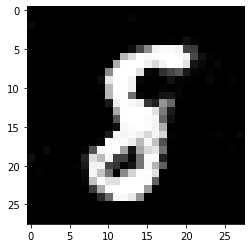

Epoch [120/200], Step [200/600], d_loss: 0.9728, g_loss: 2.1087, D(x): 0.66, D(G(z)): 0.25
Epoch [120/200], Step [400/600], d_loss: 0.8110, g_loss: 1.4466, D(x): 0.80, D(G(z)): 0.34
Epoch [120/200], Step [600/600], d_loss: 0.7352, g_loss: 1.7213, D(x): 0.73, D(G(z)): 0.22


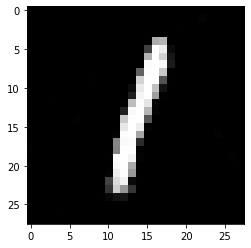

Epoch [121/200], Step [200/600], d_loss: 0.7015, g_loss: 1.8841, D(x): 0.80, D(G(z)): 0.30
Epoch [121/200], Step [400/600], d_loss: 0.7986, g_loss: 2.2675, D(x): 0.75, D(G(z)): 0.28
Epoch [121/200], Step [600/600], d_loss: 0.9606, g_loss: 1.7003, D(x): 0.67, D(G(z)): 0.28


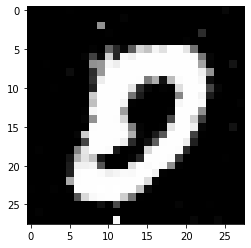

Epoch [122/200], Step [200/600], d_loss: 0.8967, g_loss: 2.2117, D(x): 0.69, D(G(z)): 0.27
Epoch [122/200], Step [400/600], d_loss: 1.0422, g_loss: 1.5837, D(x): 0.76, D(G(z)): 0.40
Epoch [122/200], Step [600/600], d_loss: 0.8173, g_loss: 2.1839, D(x): 0.70, D(G(z)): 0.25


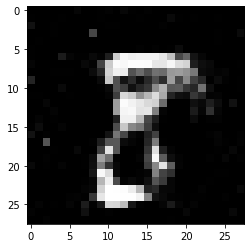

Epoch [123/200], Step [200/600], d_loss: 0.8146, g_loss: 1.6639, D(x): 0.76, D(G(z)): 0.29
Epoch [123/200], Step [400/600], d_loss: 0.7490, g_loss: 1.9298, D(x): 0.77, D(G(z)): 0.29
Epoch [123/200], Step [600/600], d_loss: 0.8541, g_loss: 2.0642, D(x): 0.68, D(G(z)): 0.25


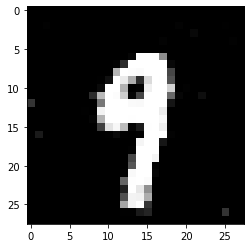

Epoch [124/200], Step [200/600], d_loss: 0.7004, g_loss: 2.1855, D(x): 0.72, D(G(z)): 0.18
Epoch [124/200], Step [400/600], d_loss: 0.8264, g_loss: 1.5528, D(x): 0.75, D(G(z)): 0.28
Epoch [124/200], Step [600/600], d_loss: 0.7575, g_loss: 1.9608, D(x): 0.73, D(G(z)): 0.23


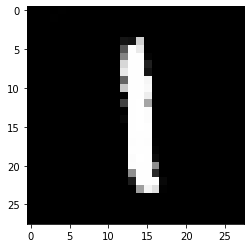

Epoch [125/200], Step [200/600], d_loss: 0.8316, g_loss: 1.7121, D(x): 0.77, D(G(z)): 0.32
Epoch [125/200], Step [400/600], d_loss: 0.6729, g_loss: 1.9697, D(x): 0.76, D(G(z)): 0.23
Epoch [125/200], Step [600/600], d_loss: 0.9900, g_loss: 1.7042, D(x): 0.71, D(G(z)): 0.35


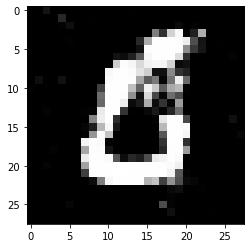

Epoch [126/200], Step [200/600], d_loss: 0.7060, g_loss: 2.0194, D(x): 0.74, D(G(z)): 0.19
Epoch [126/200], Step [400/600], d_loss: 0.7540, g_loss: 1.7690, D(x): 0.76, D(G(z)): 0.26
Epoch [126/200], Step [600/600], d_loss: 0.8025, g_loss: 2.2159, D(x): 0.67, D(G(z)): 0.20


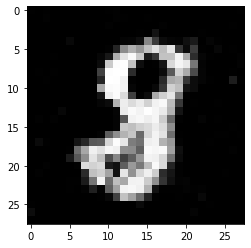

Epoch [127/200], Step [200/600], d_loss: 0.8901, g_loss: 1.8056, D(x): 0.74, D(G(z)): 0.32
Epoch [127/200], Step [400/600], d_loss: 0.7285, g_loss: 1.6167, D(x): 0.73, D(G(z)): 0.25
Epoch [127/200], Step [600/600], d_loss: 0.8576, g_loss: 1.6334, D(x): 0.68, D(G(z)): 0.24


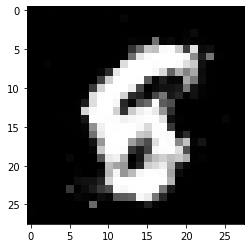

Epoch [128/200], Step [200/600], d_loss: 0.7100, g_loss: 1.4172, D(x): 0.71, D(G(z)): 0.19
Epoch [128/200], Step [400/600], d_loss: 0.8788, g_loss: 2.2163, D(x): 0.65, D(G(z)): 0.22
Epoch [128/200], Step [600/600], d_loss: 0.9442, g_loss: 1.6653, D(x): 0.68, D(G(z)): 0.28


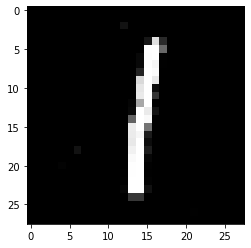

Epoch [129/200], Step [200/600], d_loss: 1.0046, g_loss: 1.5465, D(x): 0.77, D(G(z)): 0.42
Epoch [129/200], Step [400/600], d_loss: 0.7336, g_loss: 1.8587, D(x): 0.75, D(G(z)): 0.26
Epoch [129/200], Step [600/600], d_loss: 0.7530, g_loss: 1.5434, D(x): 0.75, D(G(z)): 0.28


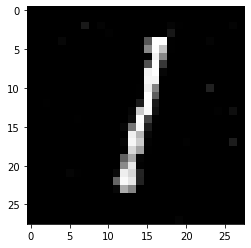

Epoch [130/200], Step [200/600], d_loss: 0.6721, g_loss: 1.8430, D(x): 0.72, D(G(z)): 0.16
Epoch [130/200], Step [400/600], d_loss: 0.7602, g_loss: 1.3466, D(x): 0.74, D(G(z)): 0.27
Epoch [130/200], Step [600/600], d_loss: 1.0049, g_loss: 1.6893, D(x): 0.73, D(G(z)): 0.37


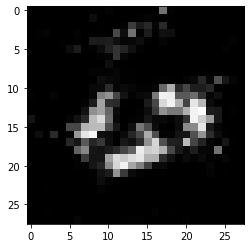

Epoch [131/200], Step [200/600], d_loss: 0.9067, g_loss: 1.3487, D(x): 0.76, D(G(z)): 0.33
Epoch [131/200], Step [400/600], d_loss: 1.0742, g_loss: 1.5460, D(x): 0.69, D(G(z)): 0.33
Epoch [131/200], Step [600/600], d_loss: 0.7204, g_loss: 2.0936, D(x): 0.70, D(G(z)): 0.20


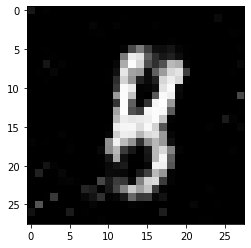

Epoch [132/200], Step [200/600], d_loss: 0.7618, g_loss: 1.3860, D(x): 0.82, D(G(z)): 0.33
Epoch [132/200], Step [400/600], d_loss: 1.0014, g_loss: 1.3330, D(x): 0.78, D(G(z)): 0.42
Epoch [132/200], Step [600/600], d_loss: 0.8773, g_loss: 1.5992, D(x): 0.77, D(G(z)): 0.35


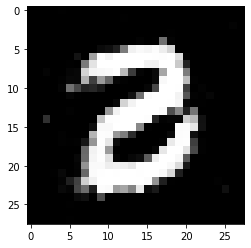

Epoch [133/200], Step [200/600], d_loss: 0.8963, g_loss: 1.6180, D(x): 0.68, D(G(z)): 0.30
Epoch [133/200], Step [400/600], d_loss: 0.8930, g_loss: 1.2893, D(x): 0.77, D(G(z)): 0.33
Epoch [133/200], Step [600/600], d_loss: 0.9375, g_loss: 1.3377, D(x): 0.72, D(G(z)): 0.32


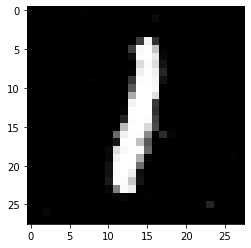

Epoch [134/200], Step [200/600], d_loss: 0.6794, g_loss: 2.3050, D(x): 0.73, D(G(z)): 0.21
Epoch [134/200], Step [400/600], d_loss: 0.8337, g_loss: 1.8622, D(x): 0.66, D(G(z)): 0.22
Epoch [134/200], Step [600/600], d_loss: 0.8020, g_loss: 2.1818, D(x): 0.72, D(G(z)): 0.26


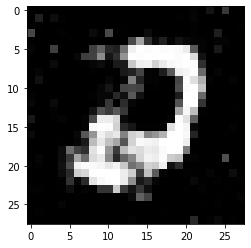

Epoch [135/200], Step [200/600], d_loss: 0.9803, g_loss: 1.5477, D(x): 0.65, D(G(z)): 0.28
Epoch [135/200], Step [400/600], d_loss: 0.8341, g_loss: 2.1177, D(x): 0.74, D(G(z)): 0.28
Epoch [135/200], Step [600/600], d_loss: 0.7680, g_loss: 1.8208, D(x): 0.77, D(G(z)): 0.30


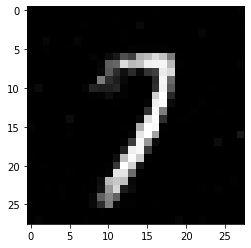

Epoch [136/200], Step [200/600], d_loss: 0.9048, g_loss: 1.9532, D(x): 0.74, D(G(z)): 0.34
Epoch [136/200], Step [400/600], d_loss: 0.8972, g_loss: 1.8505, D(x): 0.67, D(G(z)): 0.29
Epoch [136/200], Step [600/600], d_loss: 0.8386, g_loss: 1.5778, D(x): 0.74, D(G(z)): 0.28


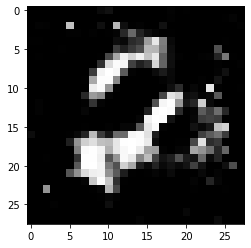

Epoch [137/200], Step [200/600], d_loss: 0.7855, g_loss: 1.8654, D(x): 0.75, D(G(z)): 0.28
Epoch [137/200], Step [400/600], d_loss: 0.8048, g_loss: 1.6618, D(x): 0.72, D(G(z)): 0.26
Epoch [137/200], Step [600/600], d_loss: 0.8798, g_loss: 1.6216, D(x): 0.74, D(G(z)): 0.33


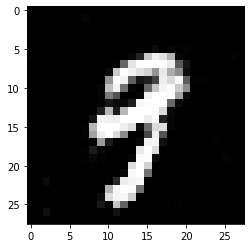

Epoch [138/200], Step [200/600], d_loss: 0.8696, g_loss: 1.1711, D(x): 0.74, D(G(z)): 0.31
Epoch [138/200], Step [400/600], d_loss: 0.9650, g_loss: 1.5038, D(x): 0.64, D(G(z)): 0.24
Epoch [138/200], Step [600/600], d_loss: 1.0535, g_loss: 1.2773, D(x): 0.70, D(G(z)): 0.34


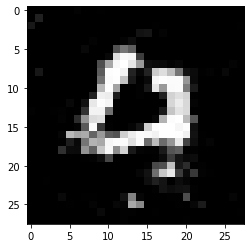

Epoch [139/200], Step [200/600], d_loss: 1.1775, g_loss: 1.6540, D(x): 0.69, D(G(z)): 0.39
Epoch [139/200], Step [400/600], d_loss: 0.7391, g_loss: 2.1837, D(x): 0.73, D(G(z)): 0.23
Epoch [139/200], Step [600/600], d_loss: 0.7733, g_loss: 1.7514, D(x): 0.69, D(G(z)): 0.22


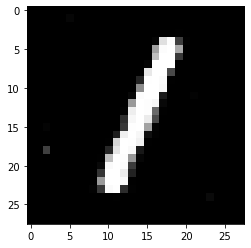

Epoch [140/200], Step [200/600], d_loss: 0.8683, g_loss: 1.6862, D(x): 0.67, D(G(z)): 0.24
Epoch [140/200], Step [400/600], d_loss: 0.8251, g_loss: 1.8304, D(x): 0.75, D(G(z)): 0.29
Epoch [140/200], Step [600/600], d_loss: 1.1460, g_loss: 1.1965, D(x): 0.70, D(G(z)): 0.41


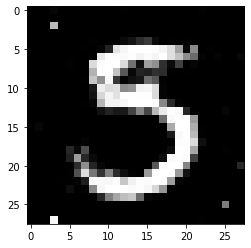

Epoch [141/200], Step [200/600], d_loss: 0.9059, g_loss: 1.8054, D(x): 0.68, D(G(z)): 0.28
Epoch [141/200], Step [400/600], d_loss: 1.0259, g_loss: 1.1989, D(x): 0.77, D(G(z)): 0.43
Epoch [141/200], Step [600/600], d_loss: 1.0475, g_loss: 1.0862, D(x): 0.68, D(G(z)): 0.38


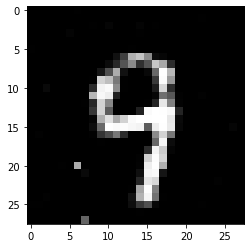

Epoch [142/200], Step [200/600], d_loss: 0.9470, g_loss: 1.9469, D(x): 0.62, D(G(z)): 0.22
Epoch [142/200], Step [400/600], d_loss: 0.9227, g_loss: 1.3939, D(x): 0.69, D(G(z)): 0.32
Epoch [142/200], Step [600/600], d_loss: 0.9197, g_loss: 1.1614, D(x): 0.75, D(G(z)): 0.38


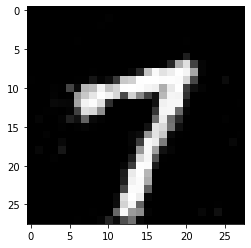

Epoch [143/200], Step [200/600], d_loss: 0.7484, g_loss: 1.6843, D(x): 0.73, D(G(z)): 0.24
Epoch [143/200], Step [400/600], d_loss: 1.0121, g_loss: 1.4420, D(x): 0.71, D(G(z)): 0.36
Epoch [143/200], Step [600/600], d_loss: 0.9874, g_loss: 2.1461, D(x): 0.60, D(G(z)): 0.23


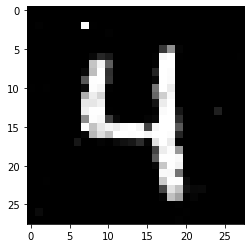

Epoch [144/200], Step [200/600], d_loss: 0.7858, g_loss: 1.9508, D(x): 0.77, D(G(z)): 0.30
Epoch [144/200], Step [400/600], d_loss: 0.8780, g_loss: 1.9198, D(x): 0.78, D(G(z)): 0.35
Epoch [144/200], Step [600/600], d_loss: 0.8409, g_loss: 1.5439, D(x): 0.71, D(G(z)): 0.28


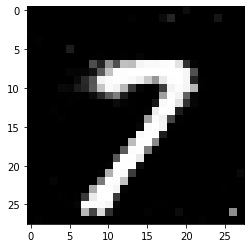

Epoch [145/200], Step [200/600], d_loss: 0.9266, g_loss: 1.4489, D(x): 0.71, D(G(z)): 0.32
Epoch [145/200], Step [400/600], d_loss: 0.7122, g_loss: 1.7932, D(x): 0.73, D(G(z)): 0.22
Epoch [145/200], Step [600/600], d_loss: 0.9572, g_loss: 1.5544, D(x): 0.66, D(G(z)): 0.28


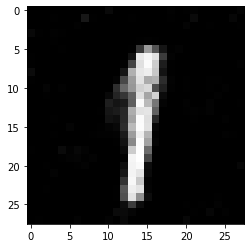

Epoch [146/200], Step [200/600], d_loss: 0.7088, g_loss: 1.6868, D(x): 0.78, D(G(z)): 0.27
Epoch [146/200], Step [400/600], d_loss: 0.8602, g_loss: 1.8202, D(x): 0.70, D(G(z)): 0.26
Epoch [146/200], Step [600/600], d_loss: 0.8649, g_loss: 1.6622, D(x): 0.75, D(G(z)): 0.33


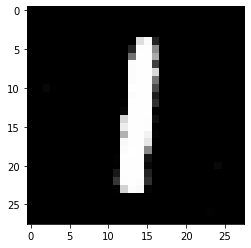

Epoch [147/200], Step [200/600], d_loss: 0.9409, g_loss: 1.5341, D(x): 0.66, D(G(z)): 0.28
Epoch [147/200], Step [400/600], d_loss: 0.9649, g_loss: 1.3146, D(x): 0.71, D(G(z)): 0.33
Epoch [147/200], Step [600/600], d_loss: 1.0400, g_loss: 1.2737, D(x): 0.66, D(G(z)): 0.30


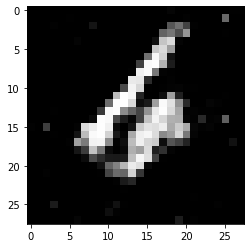

Epoch [148/200], Step [200/600], d_loss: 0.9318, g_loss: 2.0061, D(x): 0.74, D(G(z)): 0.35
Epoch [148/200], Step [400/600], d_loss: 0.8678, g_loss: 1.3939, D(x): 0.77, D(G(z)): 0.35
Epoch [148/200], Step [600/600], d_loss: 0.7693, g_loss: 2.1188, D(x): 0.72, D(G(z)): 0.24


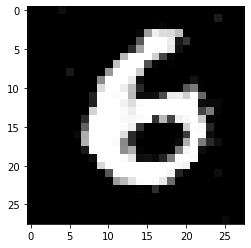

Epoch [149/200], Step [200/600], d_loss: 0.8233, g_loss: 1.8091, D(x): 0.69, D(G(z)): 0.25
Epoch [149/200], Step [400/600], d_loss: 0.9321, g_loss: 1.6546, D(x): 0.66, D(G(z)): 0.24
Epoch [149/200], Step [600/600], d_loss: 0.9648, g_loss: 1.7016, D(x): 0.71, D(G(z)): 0.33


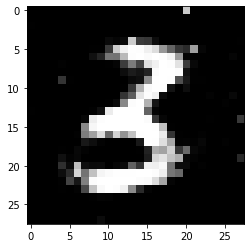

Epoch [150/200], Step [200/600], d_loss: 0.9314, g_loss: 1.6036, D(x): 0.70, D(G(z)): 0.31
Epoch [150/200], Step [400/600], d_loss: 1.0219, g_loss: 1.4550, D(x): 0.70, D(G(z)): 0.37
Epoch [150/200], Step [600/600], d_loss: 0.9016, g_loss: 1.2931, D(x): 0.71, D(G(z)): 0.31


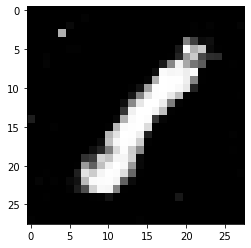

Epoch [151/200], Step [200/600], d_loss: 0.9134, g_loss: 1.8160, D(x): 0.65, D(G(z)): 0.23
Epoch [151/200], Step [400/600], d_loss: 1.0792, g_loss: 1.3981, D(x): 0.73, D(G(z)): 0.38
Epoch [151/200], Step [600/600], d_loss: 1.0320, g_loss: 1.2203, D(x): 0.66, D(G(z)): 0.31


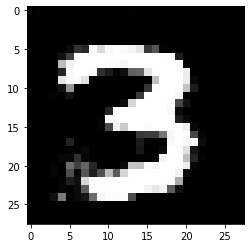

Epoch [152/200], Step [200/600], d_loss: 0.9786, g_loss: 1.8804, D(x): 0.66, D(G(z)): 0.28
Epoch [152/200], Step [400/600], d_loss: 0.8026, g_loss: 1.8182, D(x): 0.75, D(G(z)): 0.29
Epoch [152/200], Step [600/600], d_loss: 1.0975, g_loss: 1.2249, D(x): 0.67, D(G(z)): 0.36


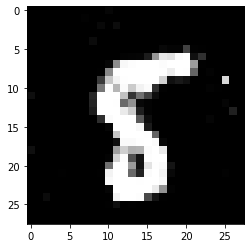

Epoch [153/200], Step [200/600], d_loss: 0.8163, g_loss: 1.5530, D(x): 0.75, D(G(z)): 0.31
Epoch [153/200], Step [400/600], d_loss: 1.0009, g_loss: 1.6674, D(x): 0.68, D(G(z)): 0.32
Epoch [153/200], Step [600/600], d_loss: 1.1087, g_loss: 1.6263, D(x): 0.63, D(G(z)): 0.30


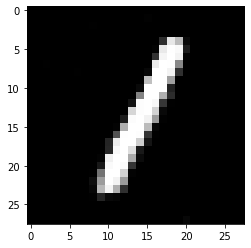

Epoch [154/200], Step [200/600], d_loss: 0.9028, g_loss: 1.9147, D(x): 0.82, D(G(z)): 0.40
Epoch [154/200], Step [400/600], d_loss: 0.9402, g_loss: 1.6296, D(x): 0.71, D(G(z)): 0.33
Epoch [154/200], Step [600/600], d_loss: 1.0794, g_loss: 1.3096, D(x): 0.70, D(G(z)): 0.35


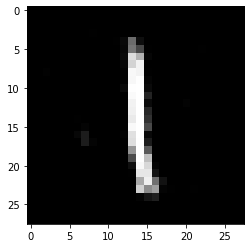

Epoch [155/200], Step [200/600], d_loss: 1.0213, g_loss: 1.8800, D(x): 0.68, D(G(z)): 0.34
Epoch [155/200], Step [400/600], d_loss: 0.9784, g_loss: 1.1613, D(x): 0.64, D(G(z)): 0.31
Epoch [155/200], Step [600/600], d_loss: 0.9361, g_loss: 1.7079, D(x): 0.70, D(G(z)): 0.30


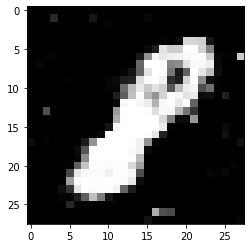

Epoch [156/200], Step [200/600], d_loss: 0.8221, g_loss: 1.5634, D(x): 0.75, D(G(z)): 0.32
Epoch [156/200], Step [400/600], d_loss: 0.6969, g_loss: 1.5698, D(x): 0.73, D(G(z)): 0.23
Epoch [156/200], Step [600/600], d_loss: 0.9661, g_loss: 1.5697, D(x): 0.75, D(G(z)): 0.37


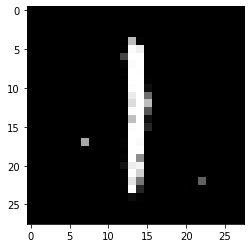

Epoch [157/200], Step [200/600], d_loss: 1.0147, g_loss: 1.5357, D(x): 0.65, D(G(z)): 0.27
Epoch [157/200], Step [400/600], d_loss: 0.9320, g_loss: 1.5871, D(x): 0.70, D(G(z)): 0.32
Epoch [157/200], Step [600/600], d_loss: 0.8314, g_loss: 1.9779, D(x): 0.69, D(G(z)): 0.26


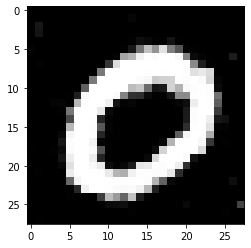

Epoch [158/200], Step [200/600], d_loss: 0.8661, g_loss: 1.4745, D(x): 0.74, D(G(z)): 0.32
Epoch [158/200], Step [400/600], d_loss: 0.8861, g_loss: 1.7747, D(x): 0.78, D(G(z)): 0.35
Epoch [158/200], Step [600/600], d_loss: 1.0421, g_loss: 1.5688, D(x): 0.64, D(G(z)): 0.29


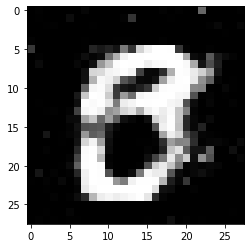

Epoch [159/200], Step [200/600], d_loss: 0.7946, g_loss: 1.4698, D(x): 0.70, D(G(z)): 0.24
Epoch [159/200], Step [400/600], d_loss: 0.9706, g_loss: 1.4908, D(x): 0.77, D(G(z)): 0.42
Epoch [159/200], Step [600/600], d_loss: 1.0188, g_loss: 1.6359, D(x): 0.66, D(G(z)): 0.32


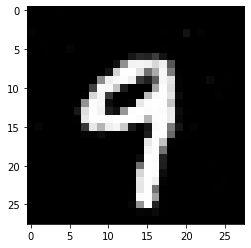

Epoch [160/200], Step [200/600], d_loss: 0.9039, g_loss: 1.4320, D(x): 0.66, D(G(z)): 0.23
Epoch [160/200], Step [400/600], d_loss: 0.7397, g_loss: 1.7568, D(x): 0.73, D(G(z)): 0.26
Epoch [160/200], Step [600/600], d_loss: 1.1803, g_loss: 1.5792, D(x): 0.56, D(G(z)): 0.23


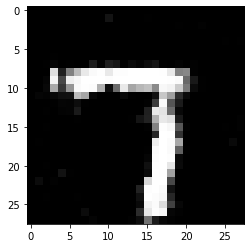

Epoch [161/200], Step [200/600], d_loss: 0.9848, g_loss: 1.4518, D(x): 0.74, D(G(z)): 0.38
Epoch [161/200], Step [400/600], d_loss: 0.9955, g_loss: 1.5683, D(x): 0.67, D(G(z)): 0.28
Epoch [161/200], Step [600/600], d_loss: 0.9976, g_loss: 1.4043, D(x): 0.70, D(G(z)): 0.35


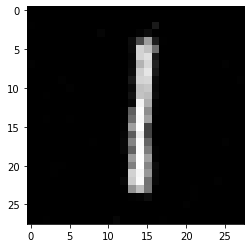

Epoch [162/200], Step [200/600], d_loss: 0.8848, g_loss: 1.4178, D(x): 0.73, D(G(z)): 0.31
Epoch [162/200], Step [400/600], d_loss: 1.0337, g_loss: 1.1724, D(x): 0.69, D(G(z)): 0.36
Epoch [162/200], Step [600/600], d_loss: 0.9804, g_loss: 1.5704, D(x): 0.75, D(G(z)): 0.38


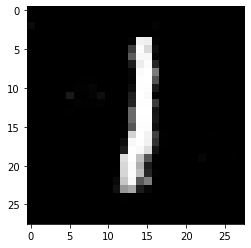

Epoch [163/200], Step [200/600], d_loss: 1.0421, g_loss: 1.4715, D(x): 0.60, D(G(z)): 0.26
Epoch [163/200], Step [400/600], d_loss: 1.0562, g_loss: 1.9024, D(x): 0.62, D(G(z)): 0.26
Epoch [163/200], Step [600/600], d_loss: 0.9311, g_loss: 1.7563, D(x): 0.72, D(G(z)): 0.35


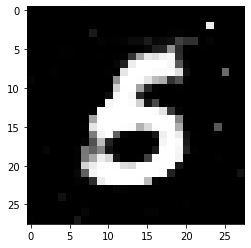

Epoch [164/200], Step [200/600], d_loss: 1.0670, g_loss: 1.1049, D(x): 0.65, D(G(z)): 0.33
Epoch [164/200], Step [400/600], d_loss: 0.8759, g_loss: 1.8258, D(x): 0.74, D(G(z)): 0.31
Epoch [164/200], Step [600/600], d_loss: 1.1696, g_loss: 1.8176, D(x): 0.56, D(G(z)): 0.25


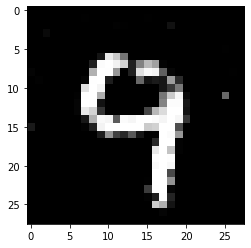

Epoch [165/200], Step [200/600], d_loss: 0.8679, g_loss: 1.7817, D(x): 0.70, D(G(z)): 0.28
Epoch [165/200], Step [400/600], d_loss: 0.9023, g_loss: 1.2325, D(x): 0.70, D(G(z)): 0.32
Epoch [165/200], Step [600/600], d_loss: 1.0841, g_loss: 1.1004, D(x): 0.68, D(G(z)): 0.41


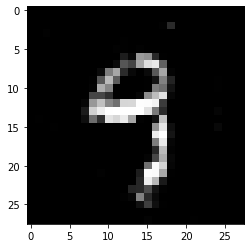

Epoch [166/200], Step [200/600], d_loss: 0.7977, g_loss: 1.4385, D(x): 0.77, D(G(z)): 0.34
Epoch [166/200], Step [400/600], d_loss: 0.8926, g_loss: 1.5752, D(x): 0.72, D(G(z)): 0.33
Epoch [166/200], Step [600/600], d_loss: 0.8300, g_loss: 1.5536, D(x): 0.75, D(G(z)): 0.30


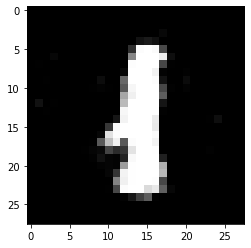

Epoch [167/200], Step [200/600], d_loss: 0.9501, g_loss: 1.7223, D(x): 0.66, D(G(z)): 0.29
Epoch [167/200], Step [400/600], d_loss: 1.0302, g_loss: 1.5939, D(x): 0.63, D(G(z)): 0.30
Epoch [167/200], Step [600/600], d_loss: 0.9046, g_loss: 1.3842, D(x): 0.70, D(G(z)): 0.31


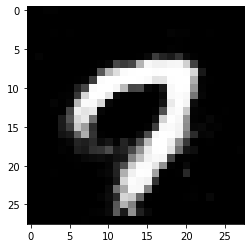

Epoch [168/200], Step [200/600], d_loss: 0.9717, g_loss: 1.8058, D(x): 0.66, D(G(z)): 0.32
Epoch [168/200], Step [400/600], d_loss: 0.9483, g_loss: 1.6838, D(x): 0.66, D(G(z)): 0.30
Epoch [168/200], Step [600/600], d_loss: 0.9014, g_loss: 1.8141, D(x): 0.72, D(G(z)): 0.34


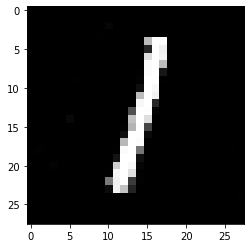

Epoch [169/200], Step [200/600], d_loss: 1.2039, g_loss: 1.7081, D(x): 0.54, D(G(z)): 0.26
Epoch [169/200], Step [400/600], d_loss: 1.0007, g_loss: 1.3984, D(x): 0.66, D(G(z)): 0.31
Epoch [169/200], Step [600/600], d_loss: 1.2655, g_loss: 1.1048, D(x): 0.66, D(G(z)): 0.40


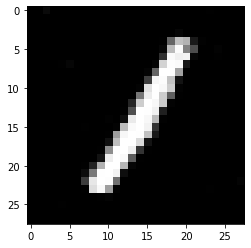

Epoch [170/200], Step [200/600], d_loss: 1.1458, g_loss: 1.6026, D(x): 0.60, D(G(z)): 0.34
Epoch [170/200], Step [400/600], d_loss: 1.0135, g_loss: 1.5053, D(x): 0.68, D(G(z)): 0.33
Epoch [170/200], Step [600/600], d_loss: 0.9737, g_loss: 1.4357, D(x): 0.80, D(G(z)): 0.42


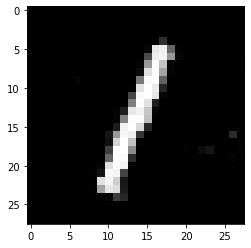

Epoch [171/200], Step [200/600], d_loss: 1.2253, g_loss: 1.1153, D(x): 0.69, D(G(z)): 0.42
Epoch [171/200], Step [400/600], d_loss: 0.8501, g_loss: 1.7649, D(x): 0.71, D(G(z)): 0.31
Epoch [171/200], Step [600/600], d_loss: 0.8103, g_loss: 1.5294, D(x): 0.75, D(G(z)): 0.30


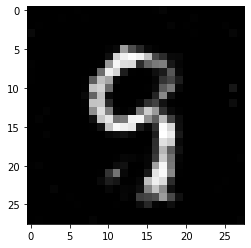

Epoch [172/200], Step [200/600], d_loss: 0.9788, g_loss: 1.6246, D(x): 0.69, D(G(z)): 0.31
Epoch [172/200], Step [400/600], d_loss: 0.8695, g_loss: 2.0477, D(x): 0.64, D(G(z)): 0.19
Epoch [172/200], Step [600/600], d_loss: 0.8582, g_loss: 1.7638, D(x): 0.67, D(G(z)): 0.23


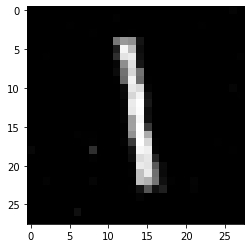

Epoch [173/200], Step [200/600], d_loss: 0.8750, g_loss: 1.4060, D(x): 0.72, D(G(z)): 0.31
Epoch [173/200], Step [400/600], d_loss: 0.8021, g_loss: 1.2879, D(x): 0.77, D(G(z)): 0.32
Epoch [173/200], Step [600/600], d_loss: 1.0057, g_loss: 1.3993, D(x): 0.65, D(G(z)): 0.32


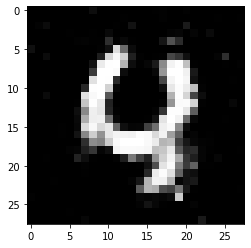

Epoch [174/200], Step [200/600], d_loss: 0.9515, g_loss: 1.4497, D(x): 0.74, D(G(z)): 0.33
Epoch [174/200], Step [400/600], d_loss: 0.9312, g_loss: 1.6331, D(x): 0.73, D(G(z)): 0.34
Epoch [174/200], Step [600/600], d_loss: 0.8948, g_loss: 1.5476, D(x): 0.62, D(G(z)): 0.22


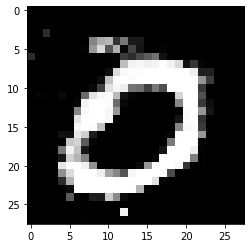

Epoch [175/200], Step [200/600], d_loss: 0.9022, g_loss: 1.5812, D(x): 0.66, D(G(z)): 0.27
Epoch [175/200], Step [400/600], d_loss: 0.8383, g_loss: 1.6108, D(x): 0.69, D(G(z)): 0.25
Epoch [175/200], Step [600/600], d_loss: 1.0076, g_loss: 1.2859, D(x): 0.69, D(G(z)): 0.36


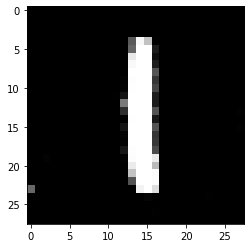

Epoch [176/200], Step [200/600], d_loss: 0.8163, g_loss: 1.7916, D(x): 0.69, D(G(z)): 0.23
Epoch [176/200], Step [400/600], d_loss: 0.9080, g_loss: 1.9287, D(x): 0.67, D(G(z)): 0.29
Epoch [176/200], Step [600/600], d_loss: 1.0259, g_loss: 1.4177, D(x): 0.79, D(G(z)): 0.43


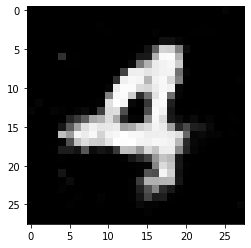

Epoch [177/200], Step [200/600], d_loss: 0.8385, g_loss: 1.1166, D(x): 0.69, D(G(z)): 0.25
Epoch [177/200], Step [400/600], d_loss: 0.8293, g_loss: 1.4673, D(x): 0.81, D(G(z)): 0.38
Epoch [177/200], Step [600/600], d_loss: 0.9981, g_loss: 1.4209, D(x): 0.71, D(G(z)): 0.37


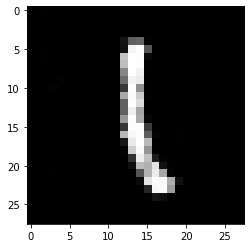

Epoch [178/200], Step [200/600], d_loss: 0.8949, g_loss: 1.5583, D(x): 0.65, D(G(z)): 0.26
Epoch [178/200], Step [400/600], d_loss: 0.9909, g_loss: 1.6561, D(x): 0.57, D(G(z)): 0.18
Epoch [178/200], Step [600/600], d_loss: 0.8821, g_loss: 1.4948, D(x): 0.73, D(G(z)): 0.32


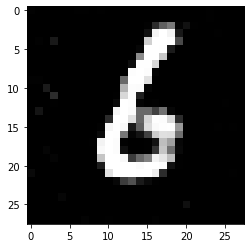

Epoch [179/200], Step [200/600], d_loss: 0.9102, g_loss: 1.6862, D(x): 0.67, D(G(z)): 0.27
Epoch [179/200], Step [400/600], d_loss: 0.9457, g_loss: 1.4601, D(x): 0.72, D(G(z)): 0.34
Epoch [179/200], Step [600/600], d_loss: 0.8809, g_loss: 1.8361, D(x): 0.69, D(G(z)): 0.29


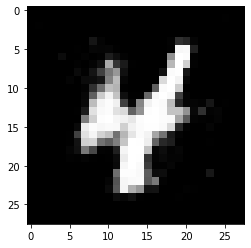

Epoch [180/200], Step [200/600], d_loss: 1.0154, g_loss: 1.3945, D(x): 0.64, D(G(z)): 0.27
Epoch [180/200], Step [400/600], d_loss: 0.9700, g_loss: 1.5708, D(x): 0.73, D(G(z)): 0.38
Epoch [180/200], Step [600/600], d_loss: 0.9730, g_loss: 1.6266, D(x): 0.72, D(G(z)): 0.36


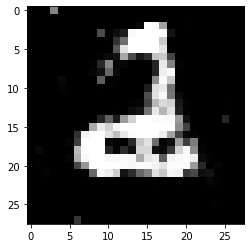

Epoch [181/200], Step [200/600], d_loss: 0.8784, g_loss: 1.6720, D(x): 0.70, D(G(z)): 0.30
Epoch [181/200], Step [400/600], d_loss: 1.1045, g_loss: 1.4377, D(x): 0.60, D(G(z)): 0.30
Epoch [181/200], Step [600/600], d_loss: 0.8532, g_loss: 1.9587, D(x): 0.71, D(G(z)): 0.28


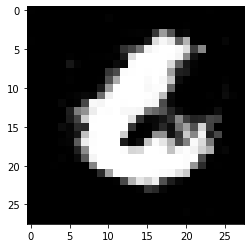

Epoch [182/200], Step [200/600], d_loss: 0.8349, g_loss: 1.5744, D(x): 0.78, D(G(z)): 0.36
Epoch [182/200], Step [400/600], d_loss: 0.8362, g_loss: 1.6599, D(x): 0.68, D(G(z)): 0.23
Epoch [182/200], Step [600/600], d_loss: 0.9858, g_loss: 1.5558, D(x): 0.67, D(G(z)): 0.30


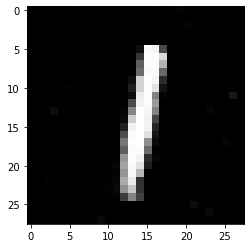

Epoch [183/200], Step [200/600], d_loss: 0.9597, g_loss: 1.7057, D(x): 0.66, D(G(z)): 0.28
Epoch [183/200], Step [400/600], d_loss: 1.0233, g_loss: 1.2972, D(x): 0.68, D(G(z)): 0.34
Epoch [183/200], Step [600/600], d_loss: 0.9372, g_loss: 1.4578, D(x): 0.69, D(G(z)): 0.34


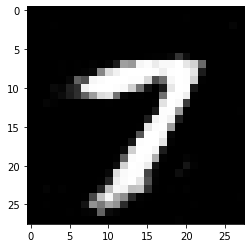

Epoch [184/200], Step [200/600], d_loss: 0.8787, g_loss: 1.8703, D(x): 0.73, D(G(z)): 0.32
Epoch [184/200], Step [400/600], d_loss: 0.8908, g_loss: 1.4365, D(x): 0.72, D(G(z)): 0.32
Epoch [184/200], Step [600/600], d_loss: 1.0400, g_loss: 1.3198, D(x): 0.68, D(G(z)): 0.39


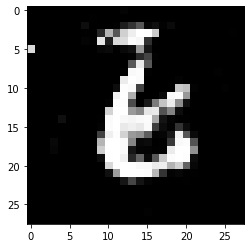

Epoch [185/200], Step [200/600], d_loss: 0.9606, g_loss: 1.6049, D(x): 0.70, D(G(z)): 0.32
Epoch [185/200], Step [400/600], d_loss: 1.0414, g_loss: 1.6024, D(x): 0.65, D(G(z)): 0.33
Epoch [185/200], Step [600/600], d_loss: 1.0830, g_loss: 1.1461, D(x): 0.72, D(G(z)): 0.42


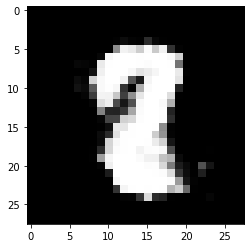

Epoch [186/200], Step [200/600], d_loss: 0.9521, g_loss: 1.4399, D(x): 0.68, D(G(z)): 0.31
Epoch [186/200], Step [400/600], d_loss: 0.8835, g_loss: 1.6969, D(x): 0.71, D(G(z)): 0.31
Epoch [186/200], Step [600/600], d_loss: 0.8846, g_loss: 1.5192, D(x): 0.74, D(G(z)): 0.32


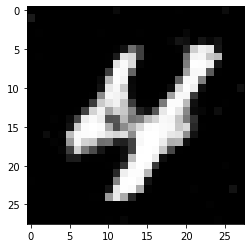

Epoch [187/200], Step [200/600], d_loss: 0.9726, g_loss: 1.6479, D(x): 0.70, D(G(z)): 0.32
Epoch [187/200], Step [400/600], d_loss: 1.0343, g_loss: 1.2197, D(x): 0.76, D(G(z)): 0.41
Epoch [187/200], Step [600/600], d_loss: 1.0949, g_loss: 1.4557, D(x): 0.72, D(G(z)): 0.44


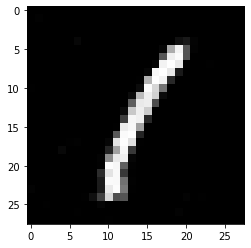

Epoch [188/200], Step [200/600], d_loss: 1.1860, g_loss: 1.3111, D(x): 0.62, D(G(z)): 0.35
Epoch [188/200], Step [400/600], d_loss: 0.8767, g_loss: 1.8229, D(x): 0.71, D(G(z)): 0.30
Epoch [188/200], Step [600/600], d_loss: 0.7837, g_loss: 1.3183, D(x): 0.70, D(G(z)): 0.25


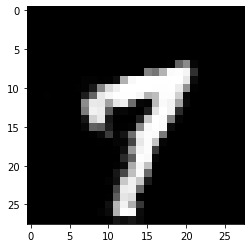

Epoch [189/200], Step [200/600], d_loss: 0.9363, g_loss: 1.4145, D(x): 0.65, D(G(z)): 0.30
Epoch [189/200], Step [400/600], d_loss: 0.7921, g_loss: 1.8259, D(x): 0.75, D(G(z)): 0.29
Epoch [189/200], Step [600/600], d_loss: 0.8162, g_loss: 1.6669, D(x): 0.75, D(G(z)): 0.31


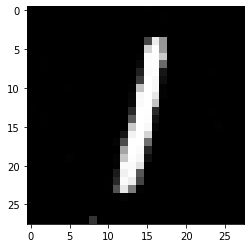

Epoch [190/200], Step [200/600], d_loss: 1.0209, g_loss: 1.5942, D(x): 0.66, D(G(z)): 0.33
Epoch [190/200], Step [400/600], d_loss: 0.8405, g_loss: 1.7720, D(x): 0.68, D(G(z)): 0.26
Epoch [190/200], Step [600/600], d_loss: 1.0007, g_loss: 1.4039, D(x): 0.68, D(G(z)): 0.34


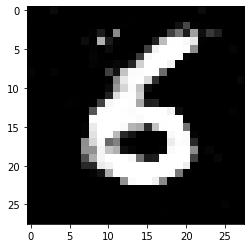

Epoch [191/200], Step [200/600], d_loss: 1.0180, g_loss: 1.7101, D(x): 0.58, D(G(z)): 0.22
Epoch [191/200], Step [400/600], d_loss: 1.0088, g_loss: 1.8877, D(x): 0.64, D(G(z)): 0.27
Epoch [191/200], Step [600/600], d_loss: 0.9883, g_loss: 1.9265, D(x): 0.70, D(G(z)): 0.33


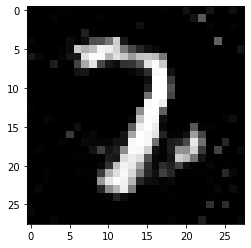

Epoch [192/200], Step [200/600], d_loss: 0.9538, g_loss: 1.8436, D(x): 0.68, D(G(z)): 0.28
Epoch [192/200], Step [400/600], d_loss: 0.8349, g_loss: 1.2167, D(x): 0.75, D(G(z)): 0.32
Epoch [192/200], Step [600/600], d_loss: 0.9990, g_loss: 1.2277, D(x): 0.69, D(G(z)): 0.36


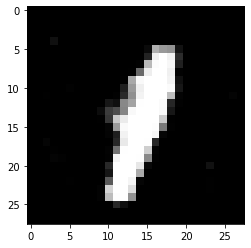

Epoch [193/200], Step [200/600], d_loss: 0.8998, g_loss: 1.4799, D(x): 0.71, D(G(z)): 0.33
Epoch [193/200], Step [400/600], d_loss: 0.8576, g_loss: 1.2872, D(x): 0.76, D(G(z)): 0.34
Epoch [193/200], Step [600/600], d_loss: 0.9600, g_loss: 1.5418, D(x): 0.71, D(G(z)): 0.35


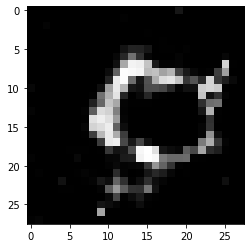

Epoch [194/200], Step [200/600], d_loss: 0.8607, g_loss: 1.6004, D(x): 0.71, D(G(z)): 0.31
Epoch [194/200], Step [400/600], d_loss: 1.0263, g_loss: 1.3332, D(x): 0.75, D(G(z)): 0.40
Epoch [194/200], Step [600/600], d_loss: 0.8312, g_loss: 1.5200, D(x): 0.65, D(G(z)): 0.22


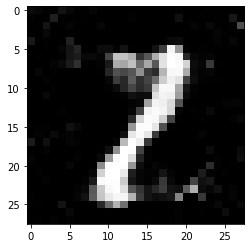

Epoch [195/200], Step [200/600], d_loss: 1.0689, g_loss: 1.1892, D(x): 0.73, D(G(z)): 0.42
Epoch [195/200], Step [400/600], d_loss: 0.9648, g_loss: 1.4469, D(x): 0.66, D(G(z)): 0.33
Epoch [195/200], Step [600/600], d_loss: 0.8241, g_loss: 1.7949, D(x): 0.75, D(G(z)): 0.32


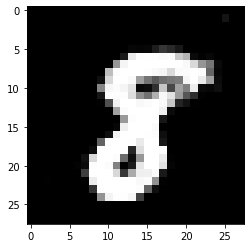

Epoch [196/200], Step [200/600], d_loss: 1.0531, g_loss: 1.8692, D(x): 0.64, D(G(z)): 0.32
Epoch [196/200], Step [400/600], d_loss: 0.9887, g_loss: 1.3147, D(x): 0.73, D(G(z)): 0.38
Epoch [196/200], Step [600/600], d_loss: 1.0412, g_loss: 1.4080, D(x): 0.70, D(G(z)): 0.39


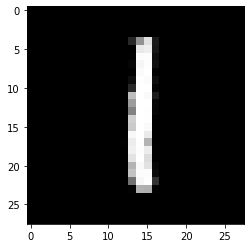

Epoch [197/200], Step [200/600], d_loss: 0.9483, g_loss: 1.3492, D(x): 0.72, D(G(z)): 0.36
Epoch [197/200], Step [400/600], d_loss: 1.0622, g_loss: 1.3215, D(x): 0.64, D(G(z)): 0.32
Epoch [197/200], Step [600/600], d_loss: 0.9058, g_loss: 1.3710, D(x): 0.67, D(G(z)): 0.30


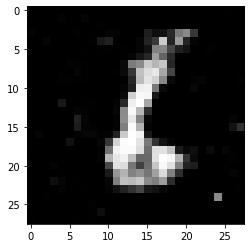

Epoch [198/200], Step [200/600], d_loss: 0.8654, g_loss: 1.5999, D(x): 0.68, D(G(z)): 0.26
Epoch [198/200], Step [400/600], d_loss: 0.8614, g_loss: 1.3512, D(x): 0.73, D(G(z)): 0.32
Epoch [198/200], Step [600/600], d_loss: 0.9265, g_loss: 1.2039, D(x): 0.73, D(G(z)): 0.36


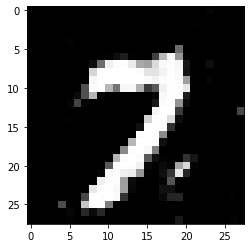

Epoch [199/200], Step [200/600], d_loss: 0.9308, g_loss: 1.5361, D(x): 0.70, D(G(z)): 0.33
Epoch [199/200], Step [400/600], d_loss: 0.8938, g_loss: 1.6638, D(x): 0.66, D(G(z)): 0.27
Epoch [199/200], Step [600/600], d_loss: 0.9308, g_loss: 1.4117, D(x): 0.72, D(G(z)): 0.34


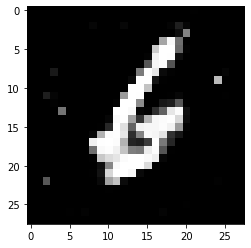

In [12]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    
    # Reshape sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

    fake_images_clone = fake_images.clone()
    im = denorm(fake_images_clone[0]).cpu().detach().numpy()
    im = (im * 255).astype(np.uint8)
    im = im.reshape((28, 28))
    imgplot = plt.imshow(im, cmap='gray')
    plt.show()

# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

## Create Augmented Dataset

In [0]:
# Device setting
D = D.to(device)
G = G.to(device)

# Create an equal number of fake images
aug_size = len(mnist)
z = torch.randn(aug_size, latent_size).to(device)
fake_dataset_images = G(z)
fake_dataset_labels = torch.zeros(aug_size, 1)
fake_dataset = (fake_dataset_images.clone().cpu().detach(), fake_dataset_labels.clone().cpu().detach())

# Ugly code to pry out data from an existing dataset
original_data = np.zeros((len(mnist), image_size))
for i in range(len(mnist)):
  original_data[i,:] = mnist[i][0].reshape(image_size,)


In [41]:
# Create augmented dataset
class AugDataset(torch.utils.data.Dataset):
    def __init__(self, original_data, generated_data):
        # Load Data 
        self.x_train = np.vstack((original_data, generated_data[0].numpy()))
      
        self.y_train = np.vstack((np.ones(((original_data.shape[0], 1))), np.zeros(((generated_data[0].numpy().shape[0], 1)))))

    def __getitem__(self, index):
        return (self.x_train[index], self.y_train[index])

    def __len__(self):
        return self.x_train.shape[0]

# Init dataset
ds = AugDataset(original_data, fake_dataset)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

[0.]


# Create Classifier

In [0]:
# Fully connected neural network with the same architecture as the Discriminator
class NeuralNet(nn.Module):
    criterion = None
    optimizer = None

    def __init__(self, image_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(image_size, hidden_size) 
        self.relu1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.relu2 = nn.LeakyReLU(0.2)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.sig = nn.Sigmoid()

        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sig(out)
        return out

# Create model
clf = NeuralNet(image_size, hidden_size).to(device)

## Train Classifier

In [0]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))